<a href="https://www.kaggle.com/code/m000sey/ps-3-25-predicting-hardness-w-boosts-nn?scriptVersionId=151715250" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

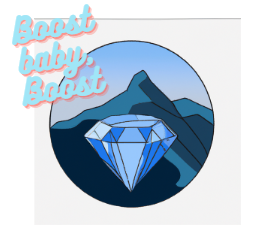

### <span style="font=family:Arial; font-weight:bold; color:green; font-size:150%;">Preface</span>

- I'm still working hard on this notebook.
- Things to note:
    - I focused mostly on EDA recently. I created a new feature by using kmeans clusters.
    - My next main focus is to try a neural network and integrate it into my ensemble.
        - I will try some custom architectures that have served me well in the last playground series.


In [1]:
### Import libraries
import pandas as pd
import numpy as np
from scipy import stats
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial.distance import squareform
import catboost, xgboost, lightgbm
from scipy.stats import yeojohnson
from catboost import CatBoostRegressor
from xgboost import XGBRegressor, XGBClassifier
from lightgbm import LGBMRegressor
from sklearn.ensemble import GradientBoostingRegressor, HistGradientBoostingRegressor, VotingRegressor, StackingRegressor
from sklearn.model_selection import cross_val_score, RepeatedStratifiedKFold, cross_validate, RepeatedKFold, train_test_split, KFold, StratifiedKFold
from sklearn.metrics import mean_squared_error, median_absolute_error, roc_auc_score, roc_curve
from sklearn.preprocessing import RobustScaler, MinMaxScaler, StandardScaler, LabelEncoder
from sklearn.neighbors import NearestNeighbors
from sklearn.linear_model import HuberRegressor
import sklearn.cluster as skc 
from sklearn.cluster import KMeans
import time, optuna, warnings, os, platform, time, random, gc
import seaborn as sns
import matplotlib.pyplot as plt
!pip install sklego
!pip install kneed
from sklego.linear_model import LADRegression
from kneed import KneeLocator

# Define some values
SEED = 42
FOLDS = 10
ROUNDS = 100

# Import the data
if platform.system()   == "Windows":
    train_path          = 'C:/Users/COMMANDCENTER/Desktop/coding/playground_series/hardness/train.csv'
    test_path           = 'C:/Users/COMMANDCENTER/Desktop/coding/playground_series/hardness/test.csv'
    sample_path         = 'C:/Users/COMMANDCENTER/Desktop/coding/playground_series/hardness/sample_submission.csv'
    original_1_path     = 'C:/Users/COMMANDCENTER/Desktop/coding/playground_series/hardness/original_1.csv'
    original_2_path     = 'C:/Users/COMMANDCENTER/Desktop/coding/playground_series/hardness/original_2.csv'
    print("Using Windows file path...")
elif platform.system() == "Darwin":
    train_path          = '/Users/shane/Documents/data_science/train.csv'
    test_path           = '/Users/shane/Documents/data_science/test.csv'
    print("Using Mac file path...")
elif platform.system() == "Linux":
    train_path          = '/kaggle/input/playground-series-s3e25/train.csv'
    test_path           = '/kaggle/input/playground-series-s3e25/test.csv'
    sample_path         = '/kaggle/input/playground-series-s3e25/sample_submission.csv'
    original_1_path     = '/kaggle/input/prediction-of-mohs-hardness-with-machine-learning/jm79zfps6b-1/Artificial_Crystals_Dataset.csv'
    original_2_path     = '/kaggle/input/prediction-of-mohs-hardness-with-machine-learning/jm79zfps6b-1/Mineral_Dataset_Supplementary_Info.csv'
    print("Using Linux file path...")
else:
    raise OSError("Unsupported operating system")
    
train = pd.read_csv(train_path, index_col='id')
test = pd.read_csv(test_path, index_col='id')
sample = pd.read_csv(sample_path)
original_1 = pd.read_csv(original_1_path)
original_2 = pd.read_csv(original_2_path)

  Obtaining dependency information for scikit-lego from https://files.pythonhosted.org/packages/ee/c7/59d85703bfcee1bed406f0cb4bcb10871e5327ba333ff0557d3a100014bc/scikit_lego-0.6.16-py2.py3-none-any.whl.metadata
  Obtaining dependency information for autograd>=1.2 from https://files.pythonhosted.org/packages/81/70/d5c7c2a458b8be96495c8b1634c2155beab58cbe864b7a9a5c06c2e52520/autograd-1.6.2-py3-none-any.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 229.1/229.1 kB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.3/49.3 kB 4.1 MB/s eta 0:00:00
  Obtaining dependency information for kneed from https://files.pythonhosted.org/packages/9a/1b/7e726d8616e813007874468c61790099ba21493e0ea07561b7d9fc53151c/kneed-0.8.5-py3-none-any.whl.metadata
Using Linux file path...


In [2]:
# reconfigure some of the original data
original_1 = original_1[(original_1 == 0).sum(axis=1) <= 2]
original_1 = original_1.dropna(subset=['Crystal structure'])
original_1 = original_1.drop(['Unnamed: 0', 'Formula'], axis=1)
original_2 = original_2.drop(['Unnamed: 0'], axis=1)
column_order = [col for col in original_2.columns if col != 'Hardness'] + ['Hardness']
original_2 = original_2[column_order]

# Drop duplicates
duplicates_original_2 = original_2.duplicated().sum()
print("pre-drop  duplicates in original_2:", duplicates_original_2)
original_2 = original_2.drop_duplicates()
duplicates_original_2 = original_2.duplicated().sum()
print("post-drop duplicates in original_2:", duplicates_original_2)

# add the original data to the synthetic
train = pd.concat([original_2, train])
train = train.reset_index(drop=True)

# rename some columns to make me more happy
def rename_cols(df):
    df.rename(columns={'allelectrons_Total': 'num_electrons'}, inplace=True)
    df.rename(columns={'density_Total': 'total_density'}, inplace=True)
    df.rename(columns={'allelectrons_Average': 'avg_electrons'}, inplace=True)
    df.rename(columns={'val_e_Average': 'avg_val_e'}, inplace=True)
    df.rename(columns={'atomicweight_Average': 'avg_at_wt'}, inplace=True)
    df.rename(columns={'ionenergy_Average': 'avg_ion_energy'}, inplace=True)
    df.rename(columns={'el_neg_chi_Average': 'avg_electroneg'}, inplace=True)
    df.rename(columns={'R_vdw_element_Average': 'avg_vdw_rad'}, inplace=True)
    df.rename(columns={'R_cov_element_Average': 'avg_cov_rad'}, inplace=True)
    df.rename(columns={'zaratio_Average': 'avg_PtoN'}, inplace=True)
    df.rename(columns={'density_Average': 'avg_density'}, inplace=True)
    return df
train = rename_cols(train)
test = rename_cols(test)
original_1 = rename_cols(original_1)

print("Data added...")

pre-drop  duplicates in original_2: 23
post-drop duplicates in original_2: 0
Data added...


<a id="table"></a>
### <span style="font=family:Arial; font-weight:bold; color:green; font-size:150%;">Table of contents</span>

[1. Overview](#1)

[2. KNN](#2)

[3. KMeans](#3)

[4. EDA: univariate and multivariate](#4)

[5. Optuna](#5)

[7. Voting](#7)

[9. Submission](#9)

[10. TO DO LIST](#10)

<a id="1"></a>
### <span style="font=family:Arial; font-weight:bold; color:green; font-size:150%;"> Overview </span>
> **Note:** This notebook isn't even close to being finished, but I figure I may as well practice in public so other's can see what I'm working on

> **1.** Import libraries and adjust some data

> **2.** Add a crystal structure feature from **KNN**

> **3.** Create a new feature w/ **KMeans**

> **4.** Conduct **univariate** and **mutlivariate** EDA and Ad val

> **5.** Optuna 

> **6.** Ensemble models: LGBM  HGB via **Voting**

> **7.** Submit

> **8.** TO DO

<a id="2"></a>
### <span style="font=family:Arial; font-weight:bold; color:green; font-size:150%;">KNN to impute an original feature</span>
-  This KNN was copied directly from the good work in this [notebook](https://www.kaggle.com/code/yantxx/catboost-regressor-mohs-hardness-prediction/notebook) @yantxx

In [3]:
common_columns_df = [col for col in train.columns if col in original_1.columns]
X_original = original_1[common_columns_df]
X_train = train[common_columns_df]

KNN = NearestNeighbors(n_neighbors=1, p=2) # p=2 means we're using the euclidean distance
KNN.fit(X_original)
distances_df, indices_df = KNN.kneighbors(X_train)
train['crystal_strx'] = original_1.iloc[indices_df.flatten()]['Crystal structure'].values

common_columns_test = [col for col in test.columns if col in original_1.columns]
X_test = test[common_columns_test]

distances_test, indices_test = KNN.kneighbors(X_test)
test['crystal_strx'] = original_1.iloc[indices_test.flatten()]['Crystal structure'].values

print("KNN feature created...")

# Encode the KNN feature
label_encoder = LabelEncoder()
train['crystal_strx_encoded'] = label_encoder.fit_transform(train['crystal_strx'])
test['crystal_strx_encoded'] = label_encoder.transform(test['crystal_strx'])

# Drop the original 'Crystal structure' columns
train = train.drop(['crystal_strx'], axis=1)
test = test.drop(['crystal_strx'], axis=1)

column_order = [col for col in train.columns if col != 'Hardness'] + ['Hardness']
train = train[column_order]

X = train.iloc[:, :-1]
y = train.iloc[:, -1]
z = test

KNN feature created...


<a id="3"></a>
### <span style="font=family:Arial; font-weight:bold; color:green; font-size:150%;">KMeans to compute an original feature</span>

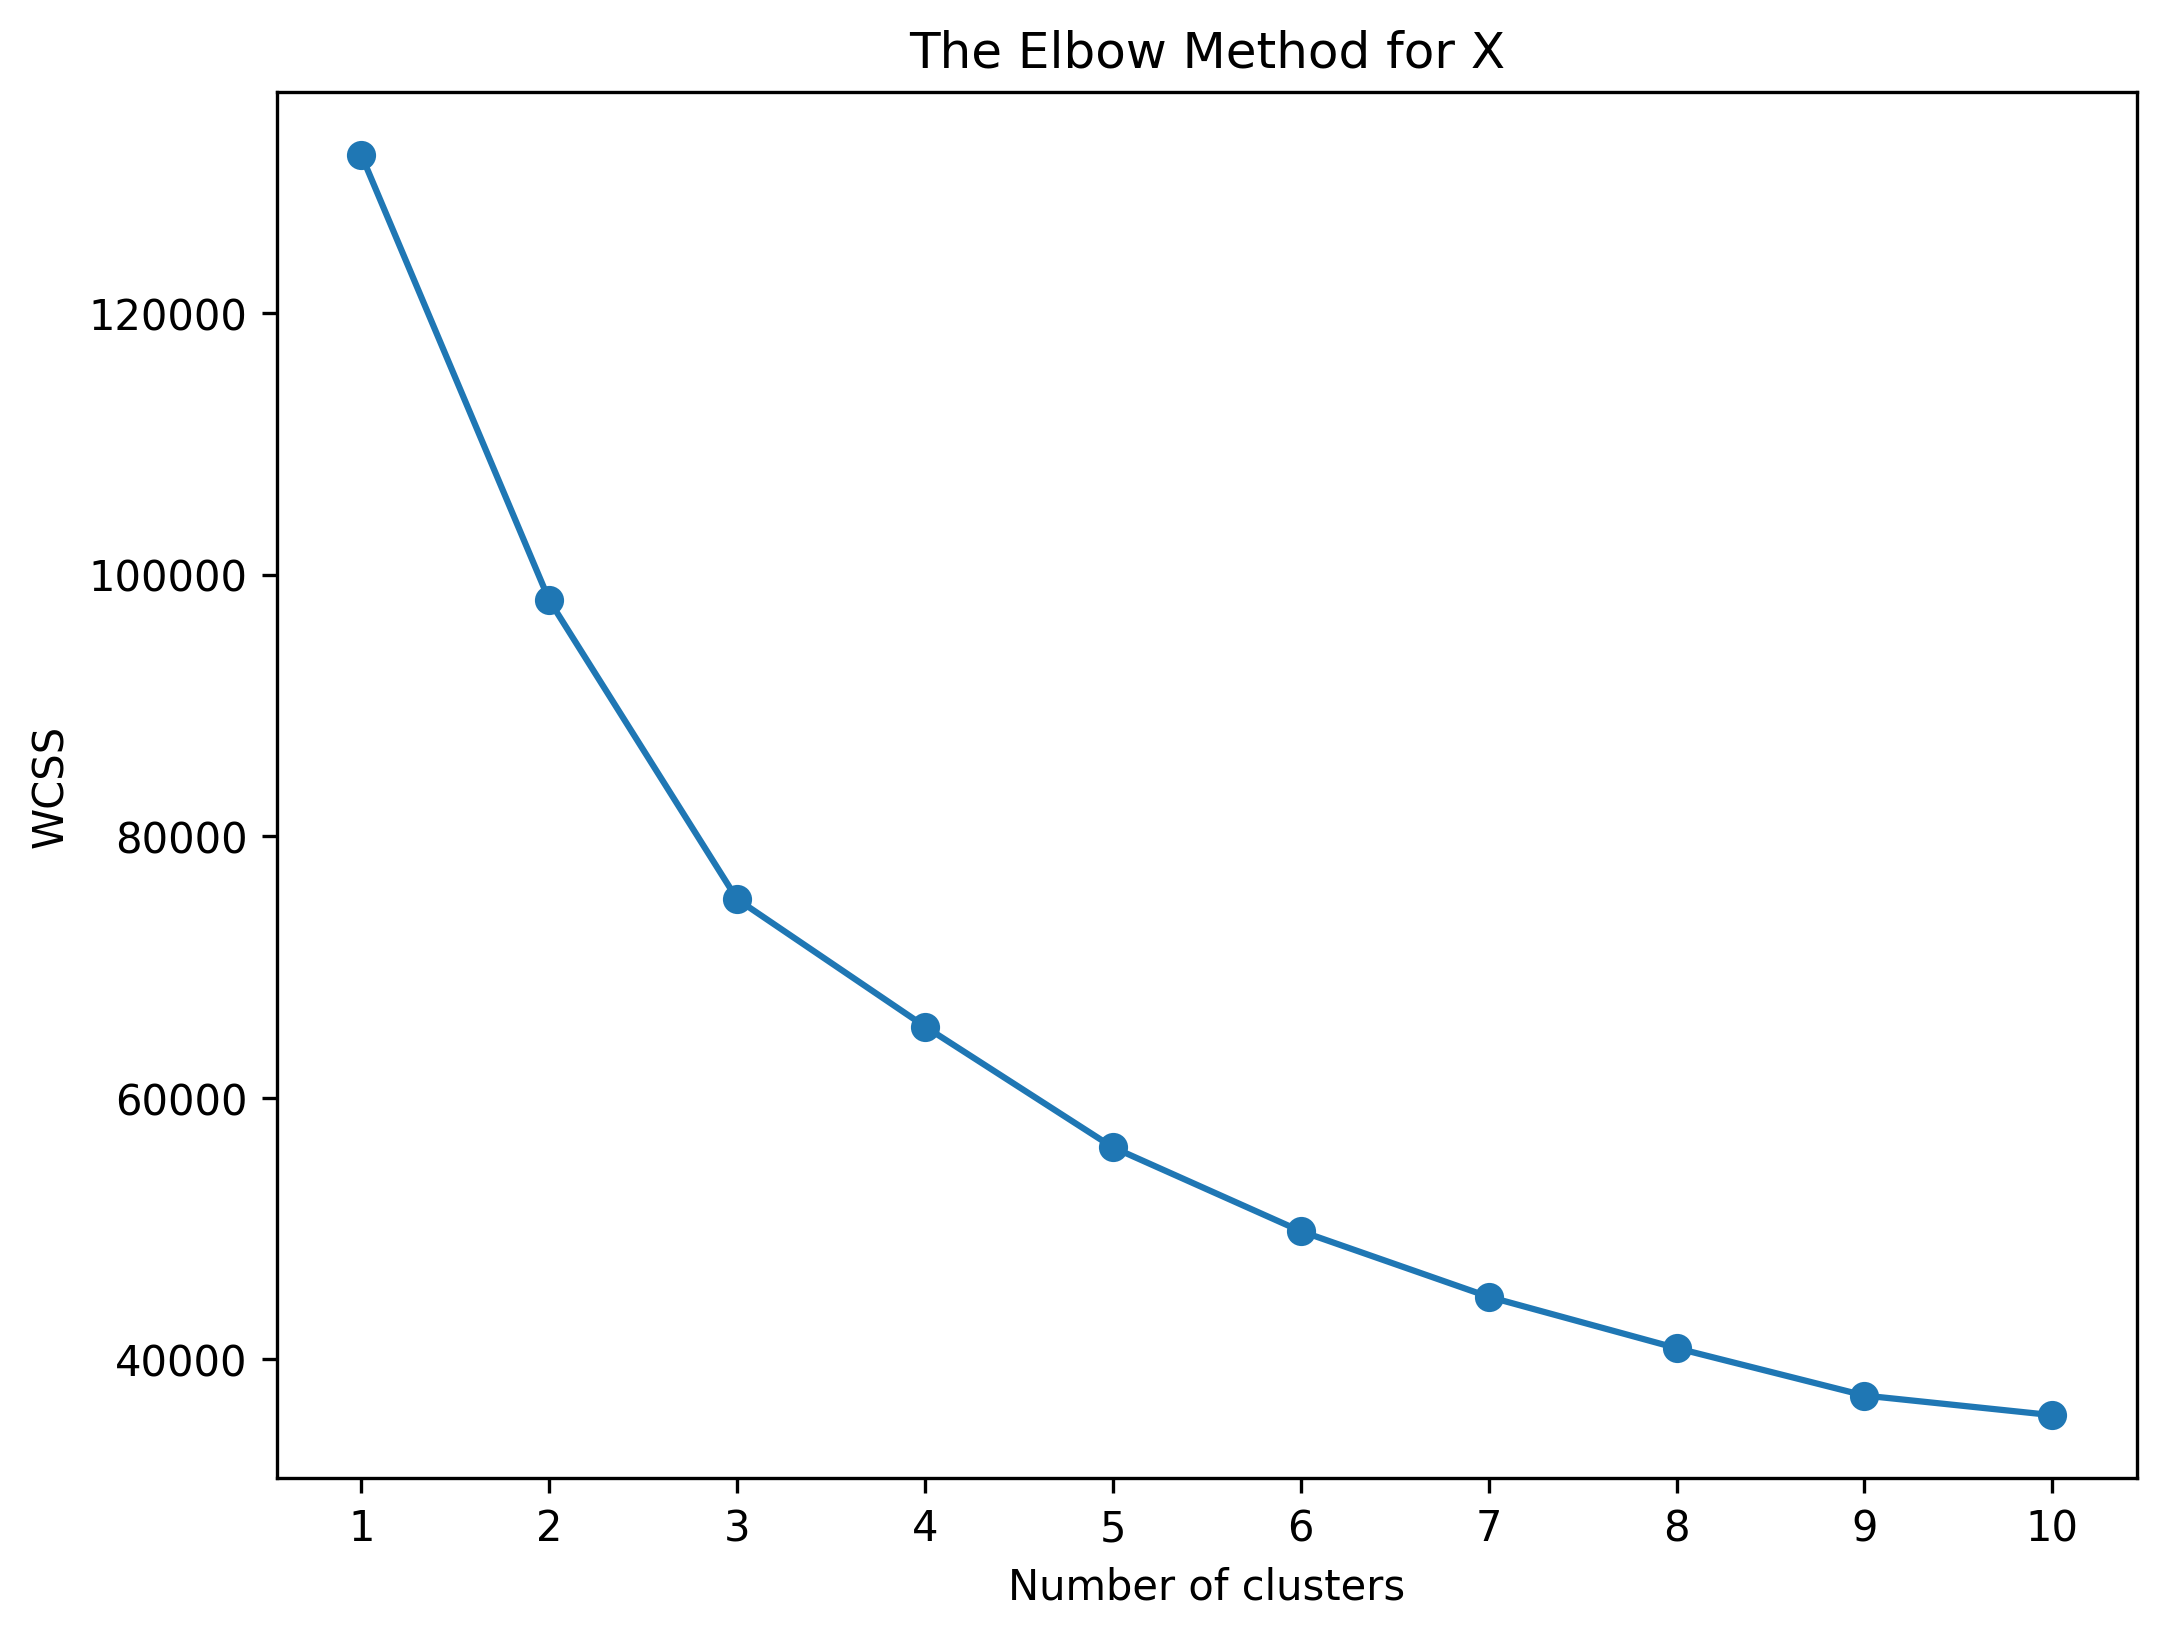

K-value from computer for X: 3
Cluster counts for X:
Cluster 1: 8454
Cluster 2: 2472
Cluster 3: 80


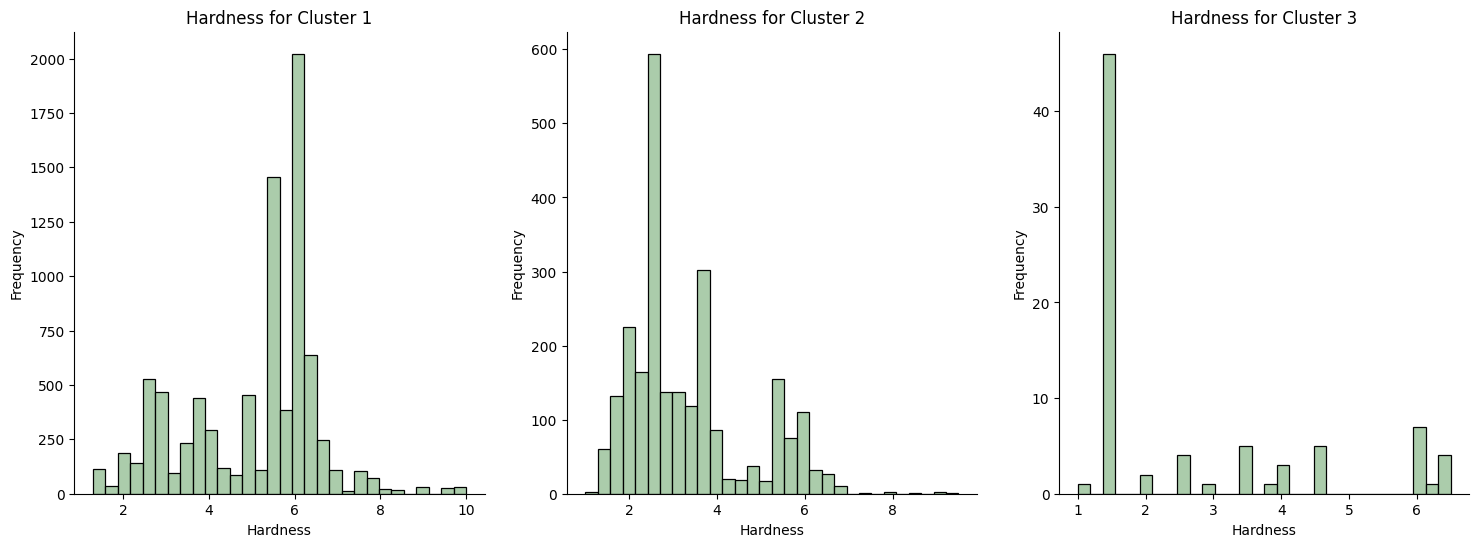

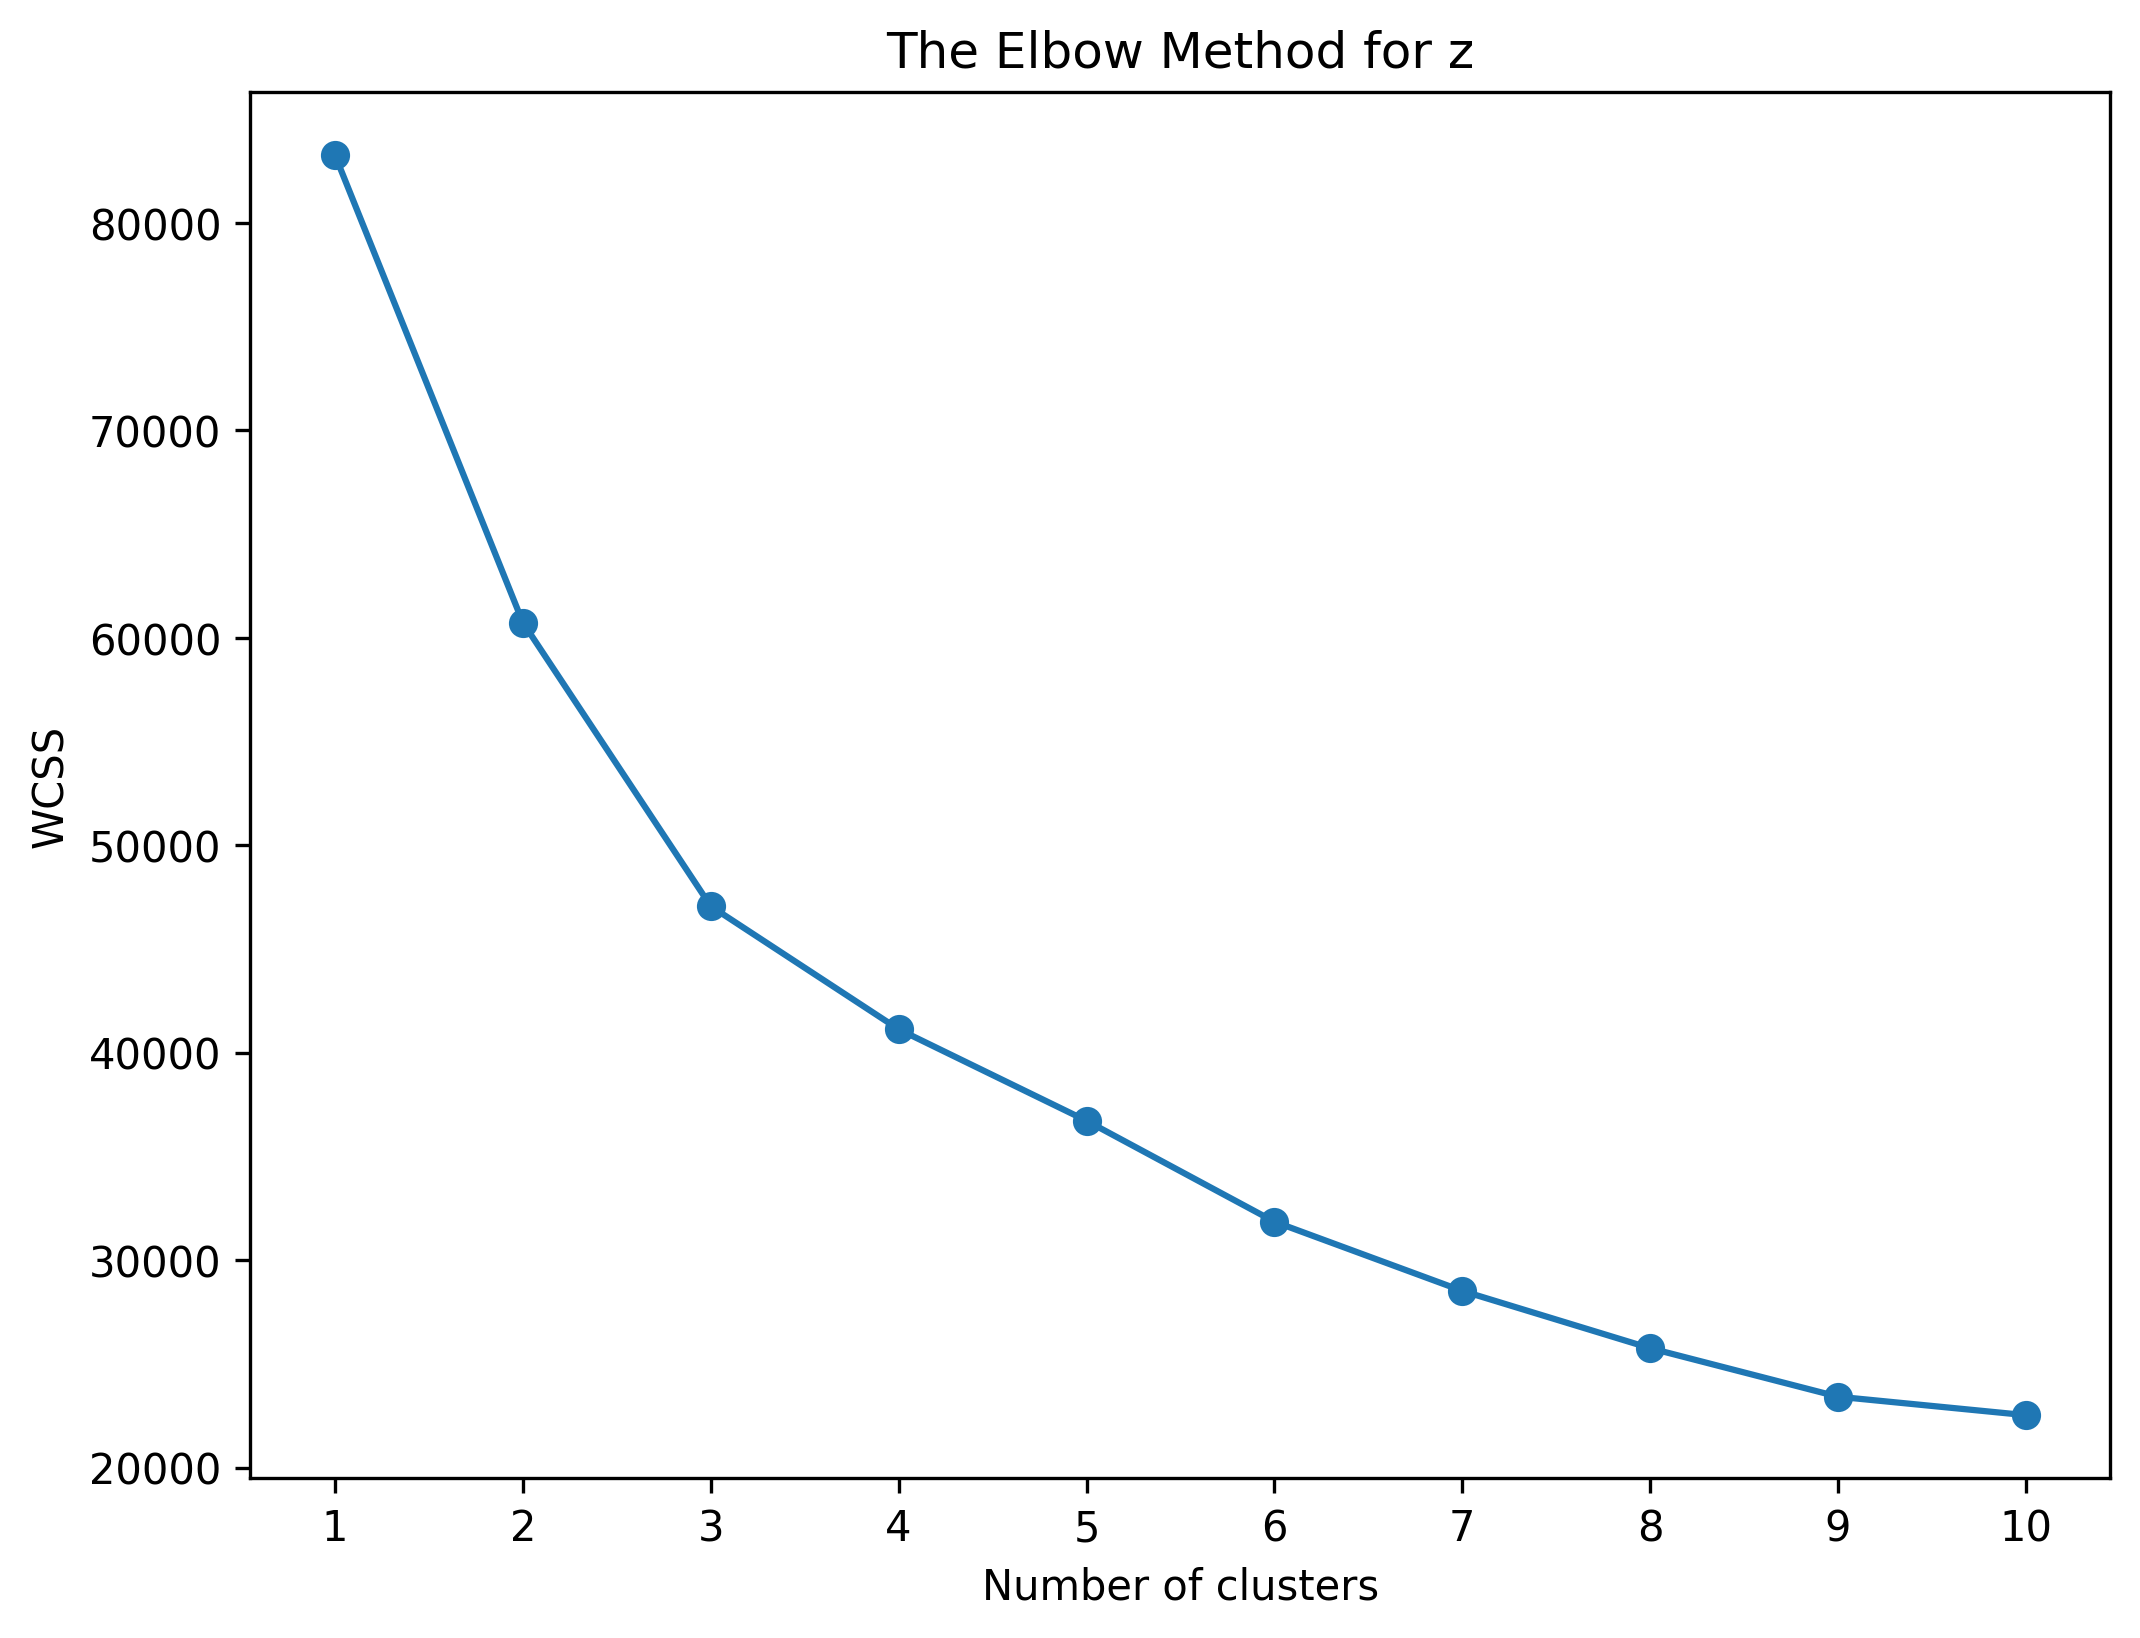

K-value from computer for z: 3
Cluster counts for z:
Cluster 1: 5340
Cluster 2: 1553
Cluster 3: 46
KMeans cluster feature created...


7301

In [4]:
def K_means(data, data_name):
    # Scale for KMeans
    scaled_data = StandardScaler().fit_transform(data)
    
    # Use human to find elbow point
    wcss = []
    k_range = range(1, 11)
    for i in k_range:
        kmeans = KMeans(n_clusters=i, init='k-means++', random_state=SEED, n_init=50)
        kmeans.fit(scaled_data)
        wcss.append(kmeans.inertia_)

    # Plot the elbow curve
    fig, ax = plt.subplots(figsize=(8, 6), dpi=300)
    plt.plot(k_range, wcss, marker='o')
    plt.xticks(k_range)
    plt.title(f'The Elbow Method for {data_name}')
    plt.xlabel('Number of clusters')
    plt.ylabel('WCSS')
    plt.show()

    # Use computer to find the elbow point
    kl = KneeLocator(k_range, wcss, curve="convex", direction="decreasing")
    print(f"K-value from computer for {data_name}: {kl.elbow}")

    # Clustering K Means, K=3
    kmeans_3 = KMeans(n_clusters=3, random_state=SEED, n_init=50)
    kmeans_3.fit(scaled_data)
    data['cluster_id'] = kmeans_3.labels_
        
    # Remap cluster labels based on counts
    count_mapping = {cluster: rank + 1 for rank, (cluster, count) in enumerate(data['cluster_id'].value_counts().items())}
    data['cluster_id'] = data['cluster_id'].map(count_mapping)
    
    # Display the counts
    cluster_counts = data['cluster_id'].value_counts()
    print(f"Cluster counts for {data_name}:")
    for cluster, count in cluster_counts.items():
        print(f'Cluster {cluster}: {count}')
    
    if data.equals(X):
        # Plot histograms of Hardness depending on cluster
        X_plus_y = pd.concat([X, y], axis=1)
        fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18, 6), sharey=False)
        for cluster, ax in zip(range(1, 4), axes):  # Adjusted cluster range
            sns.histplot(X_plus_y[X_plus_y['cluster_id'] == cluster]['Hardness'], 
                         bins=30, kde=False, color='darkseagreen', ax=ax)
            sns.despine(top=True, right=True)
            ax.set_title(f'Hardness for Cluster {cluster}')
            ax.set_xlabel('Hardness')
            ax.set_ylabel('Frequency')

K_means(X, "X")
K_means(z, "z")
print("KMeans cluster feature created...")

del train, test, test_path, train_path, original_1_path, original_2_path, column_order, distances_test
del common_columns_df, common_columns_test, sample_path, label_encoder, distances_df, duplicates_original_2
del indices_df, indices_test, KNN, X_original, X_test, X_train, original_1, original_2

gc.collect()

<a id="4"></a>
# <span style="font=family:Arial; font-weight:bold; color:green; font-size:150%;">EDA</span>
 - Let me know if there're any other EDA techniques you think I should try.

<a id="3"></a>
### <span style="font=family:Arial; font-weight:bold; color:green; font-size:150%;">Univariate analysis</span>

Train data
Train Unique Hardness Values: [1.0, 1.3, 1.5, 1.8, 2.0, 2.1, 2.2, 2.3, 2.5, 2.6, 2.8, 2.9, 3.0, 3.2, 3.3, 3.5, 3.6, 3.8, 4.0, 4.1, 4.3, 4.5, 4.7, 4.8, 5.0, 5.3, 5.4, 5.5, 5.75, 5.8, 6.0, 6.2, 6.3, 6.4, 6.5, 6.64, 6.7, 6.8, 7.0, 7.3, 7.5, 7.8, 8.0, 8.1, 8.3, 8.5, 9.0, 9.5, 9.8, 10.0]
Number of Train Unique Hardness Values: 50


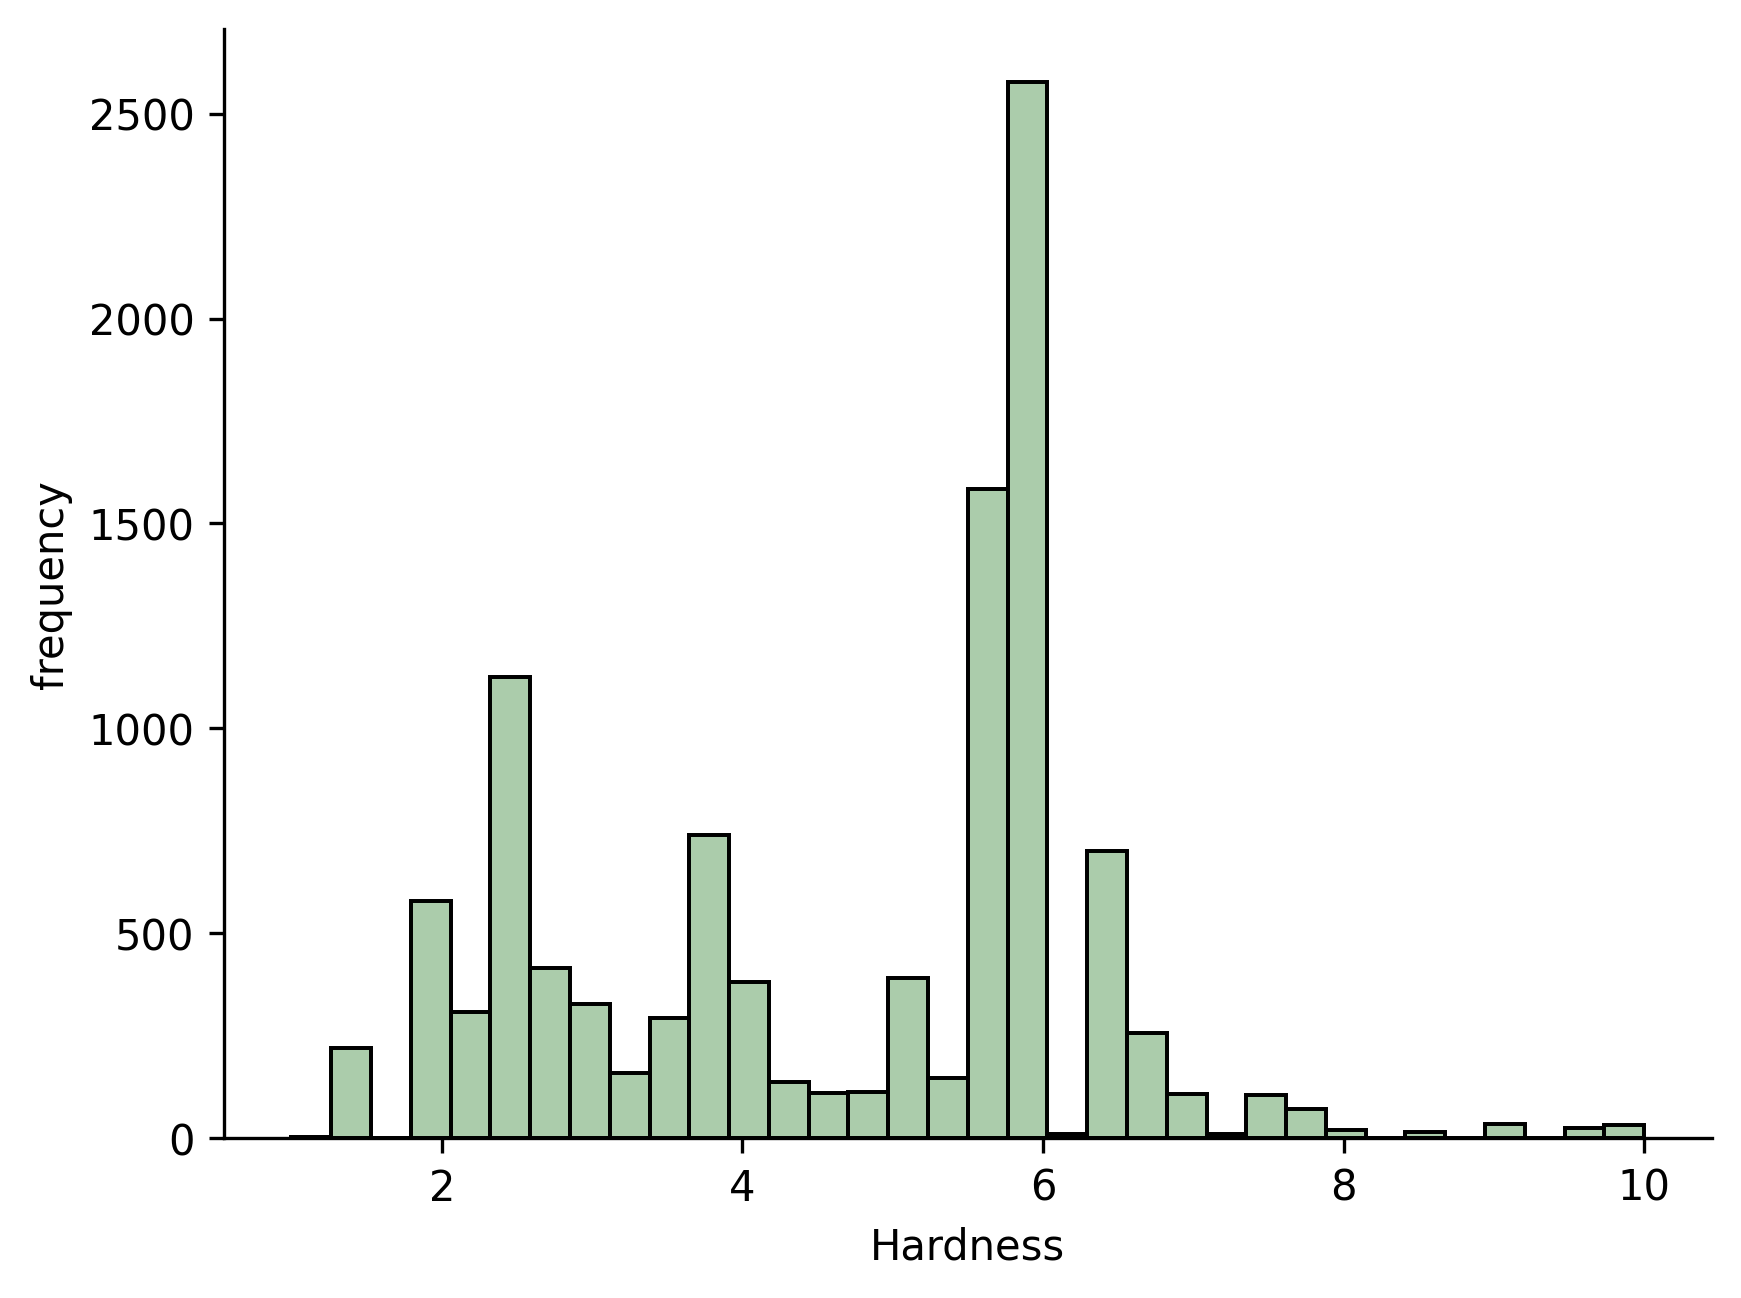

In [5]:
# Target analysis
print("Train data")
unique_hardness_values = sorted(set(y))
print("Train Unique Hardness Values:", unique_hardness_values)
num_unique_hardness_values = len(unique_hardness_values)
print("Number of Train Unique Hardness Values:", num_unique_hardness_values)

# Target distribution (train)
plt.figure(dpi=300)
sns.histplot(y, color='darkseagreen', edgecolor='black')
sns.despine(top=True, right=True)
sns.set(style="whitegrid", font='Arial')
plt.xlabel('Hardness')
plt.ylabel('frequency')
plt.show()

In [6]:
# Univariate analysis w/ histograms and boxplots
def plot_histogram_boxplots_for_dataframe(data, n_rows, n_cols):
    sns.set(style="whitegrid", font='Arial')
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 40), dpi=300)

    for i, column in enumerate(data.columns):
        ax_histo = axes[i, 0]

        ax_histo = sns.histplot(data[column], kde=False, color='darkseagreen', ax=ax_histo)  
        ax_histo.set_xlabel(column)
        ax_histo.set_ylabel("Frequency")
        ax_histo.spines['top'].set_visible(False)
        ax_histo.spines['right'].set_visible(False)
        ax_histo.grid(visible=False)
        
        ax_box = axes[i, 1]
        sns.boxplot(data=data, x=column, color='salmon', width=0.5, ax=ax_box) 
        ax_box.set_xlabel(column)
        ax_box.set_ylabel("")
        ax_box.grid(visible=False)

    plt.tight_layout()
    plt.show()

plot_histogram_boxplots_for_dataframe(X, len(X.columns), 2)
plot_histogram_boxplots_for_dataframe(z, len(z.columns), 2)

<a id="3"></a>
### <span style="font=family:Arial; font-weight:bold; color:green; font-size:150%;">Multivariate analysis</span>

<Figure size 1000x800 with 0 Axes>

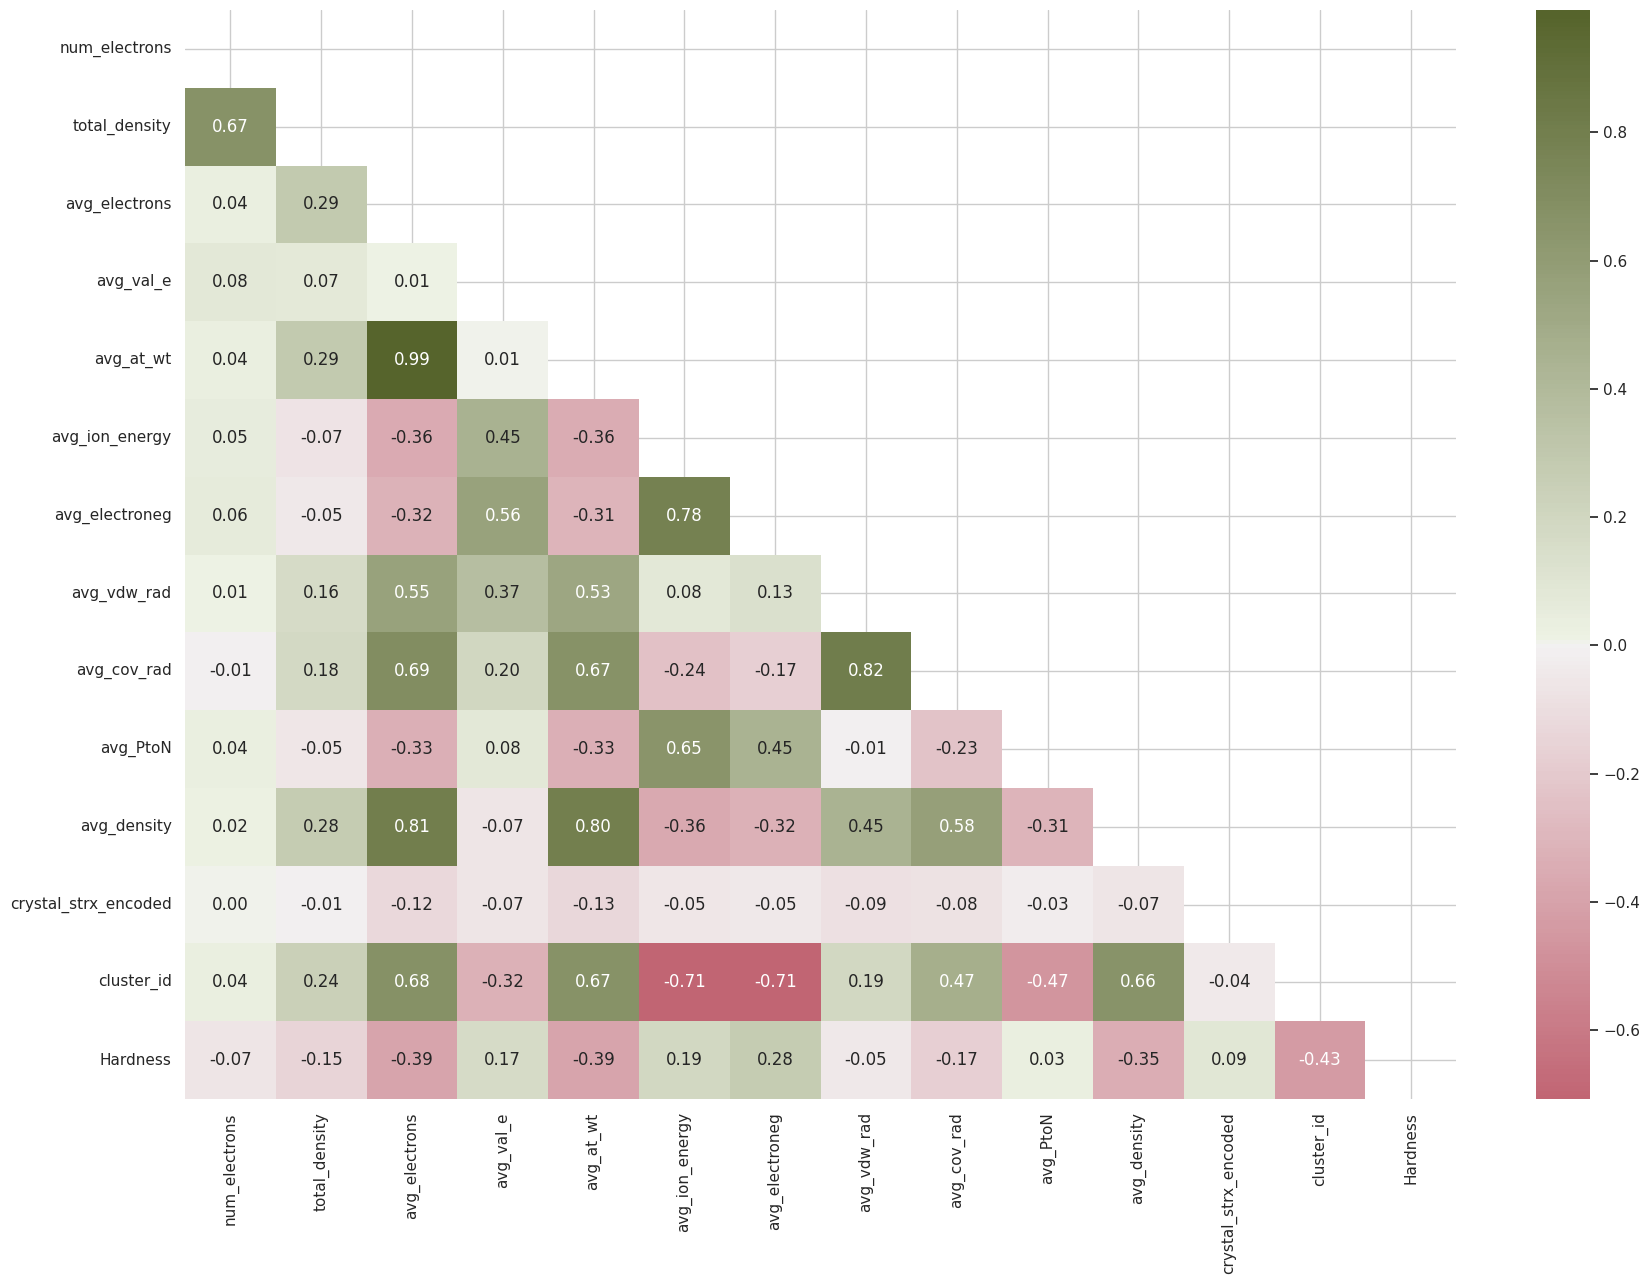

In [7]:
# Correlation matrix
X_plus_y = pd.concat([X, y], axis=1)
plt.figure(figsize=(10, 8))
corr_mat = X_plus_y.corr()
data_mask = np.triu(np.ones_like(corr_mat, dtype = bool)) 
cmap = sns.diverging_palette(7, 100, s = 75, l = 40, n = 20, center = 'light', as_cmap = True)
f, ax = plt.subplots(figsize = (18, 13))
sns.heatmap(corr_mat, annot = True, cmap = cmap, fmt = '.2f', center = 0,
            annot_kws = {'size': 12}, mask = data_mask)
plt.tight_layout()
plt.show()

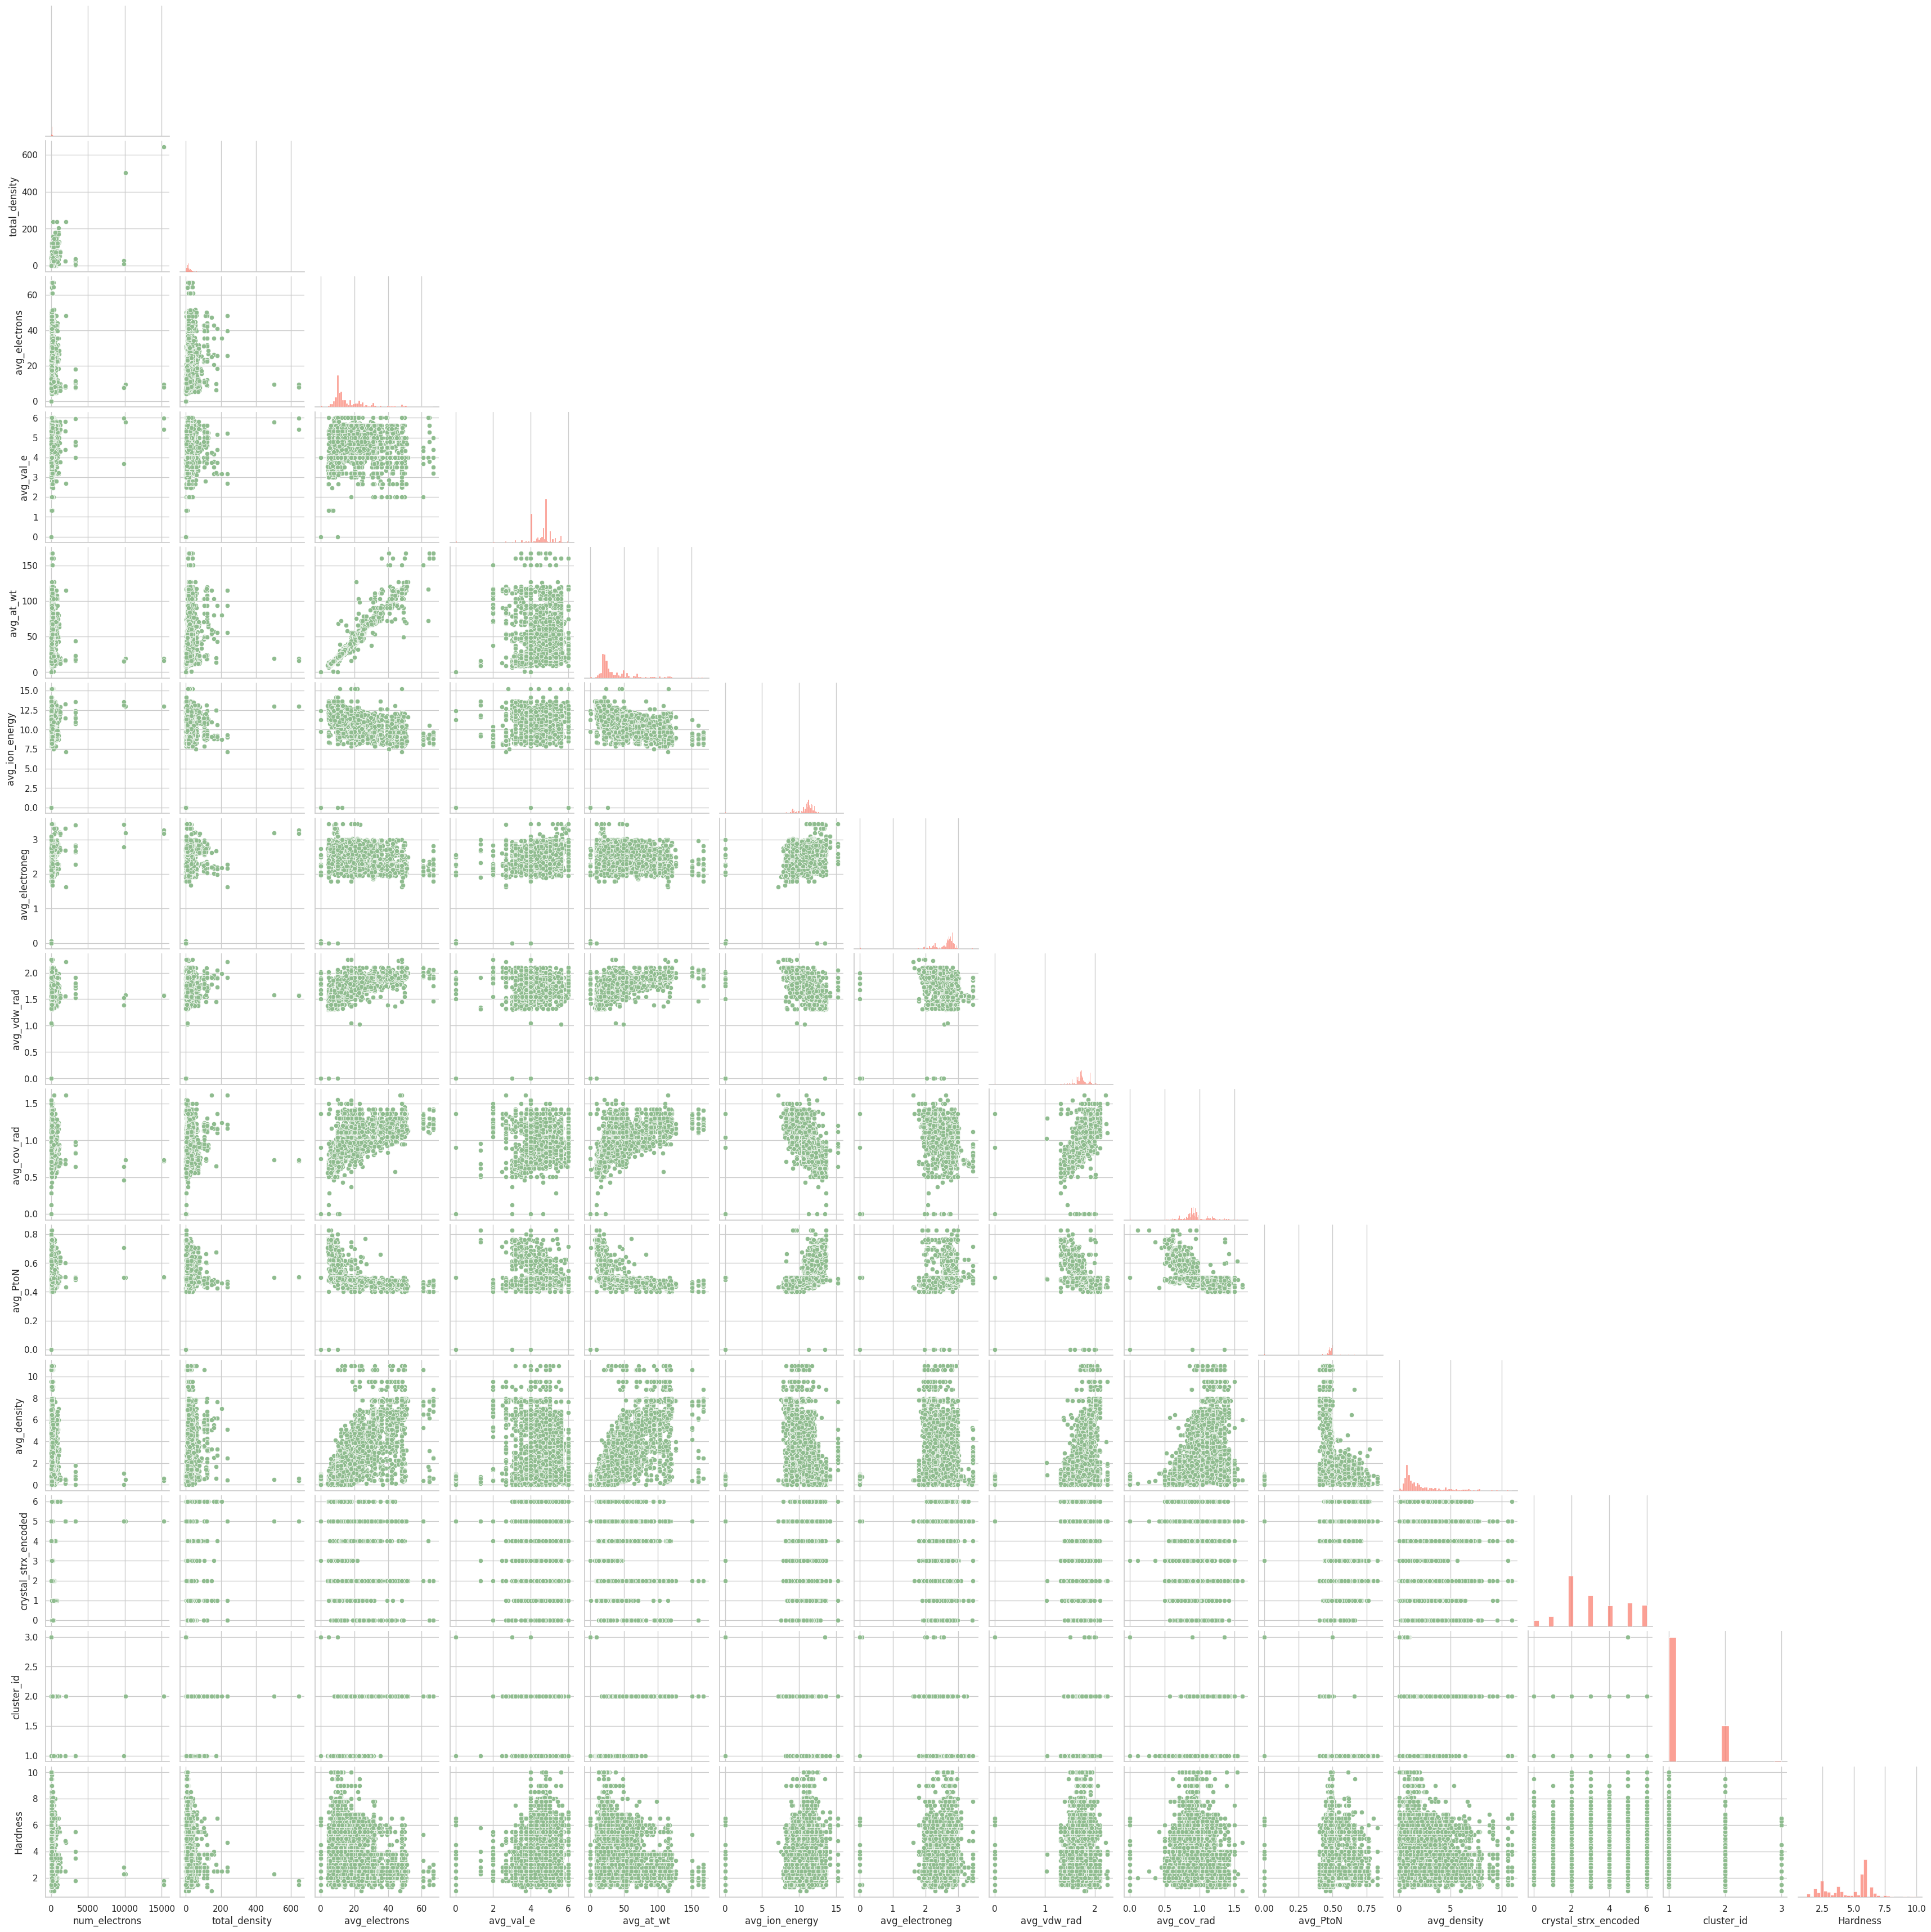

In [8]:
# Pairplot
sns.pairplot(X_plus_y, corner=True, diag_kind="hist", 
                        plot_kws={'color': 'darkseagreen'}, 
                        diag_kws={'color': 'salmon'})
plt.show()

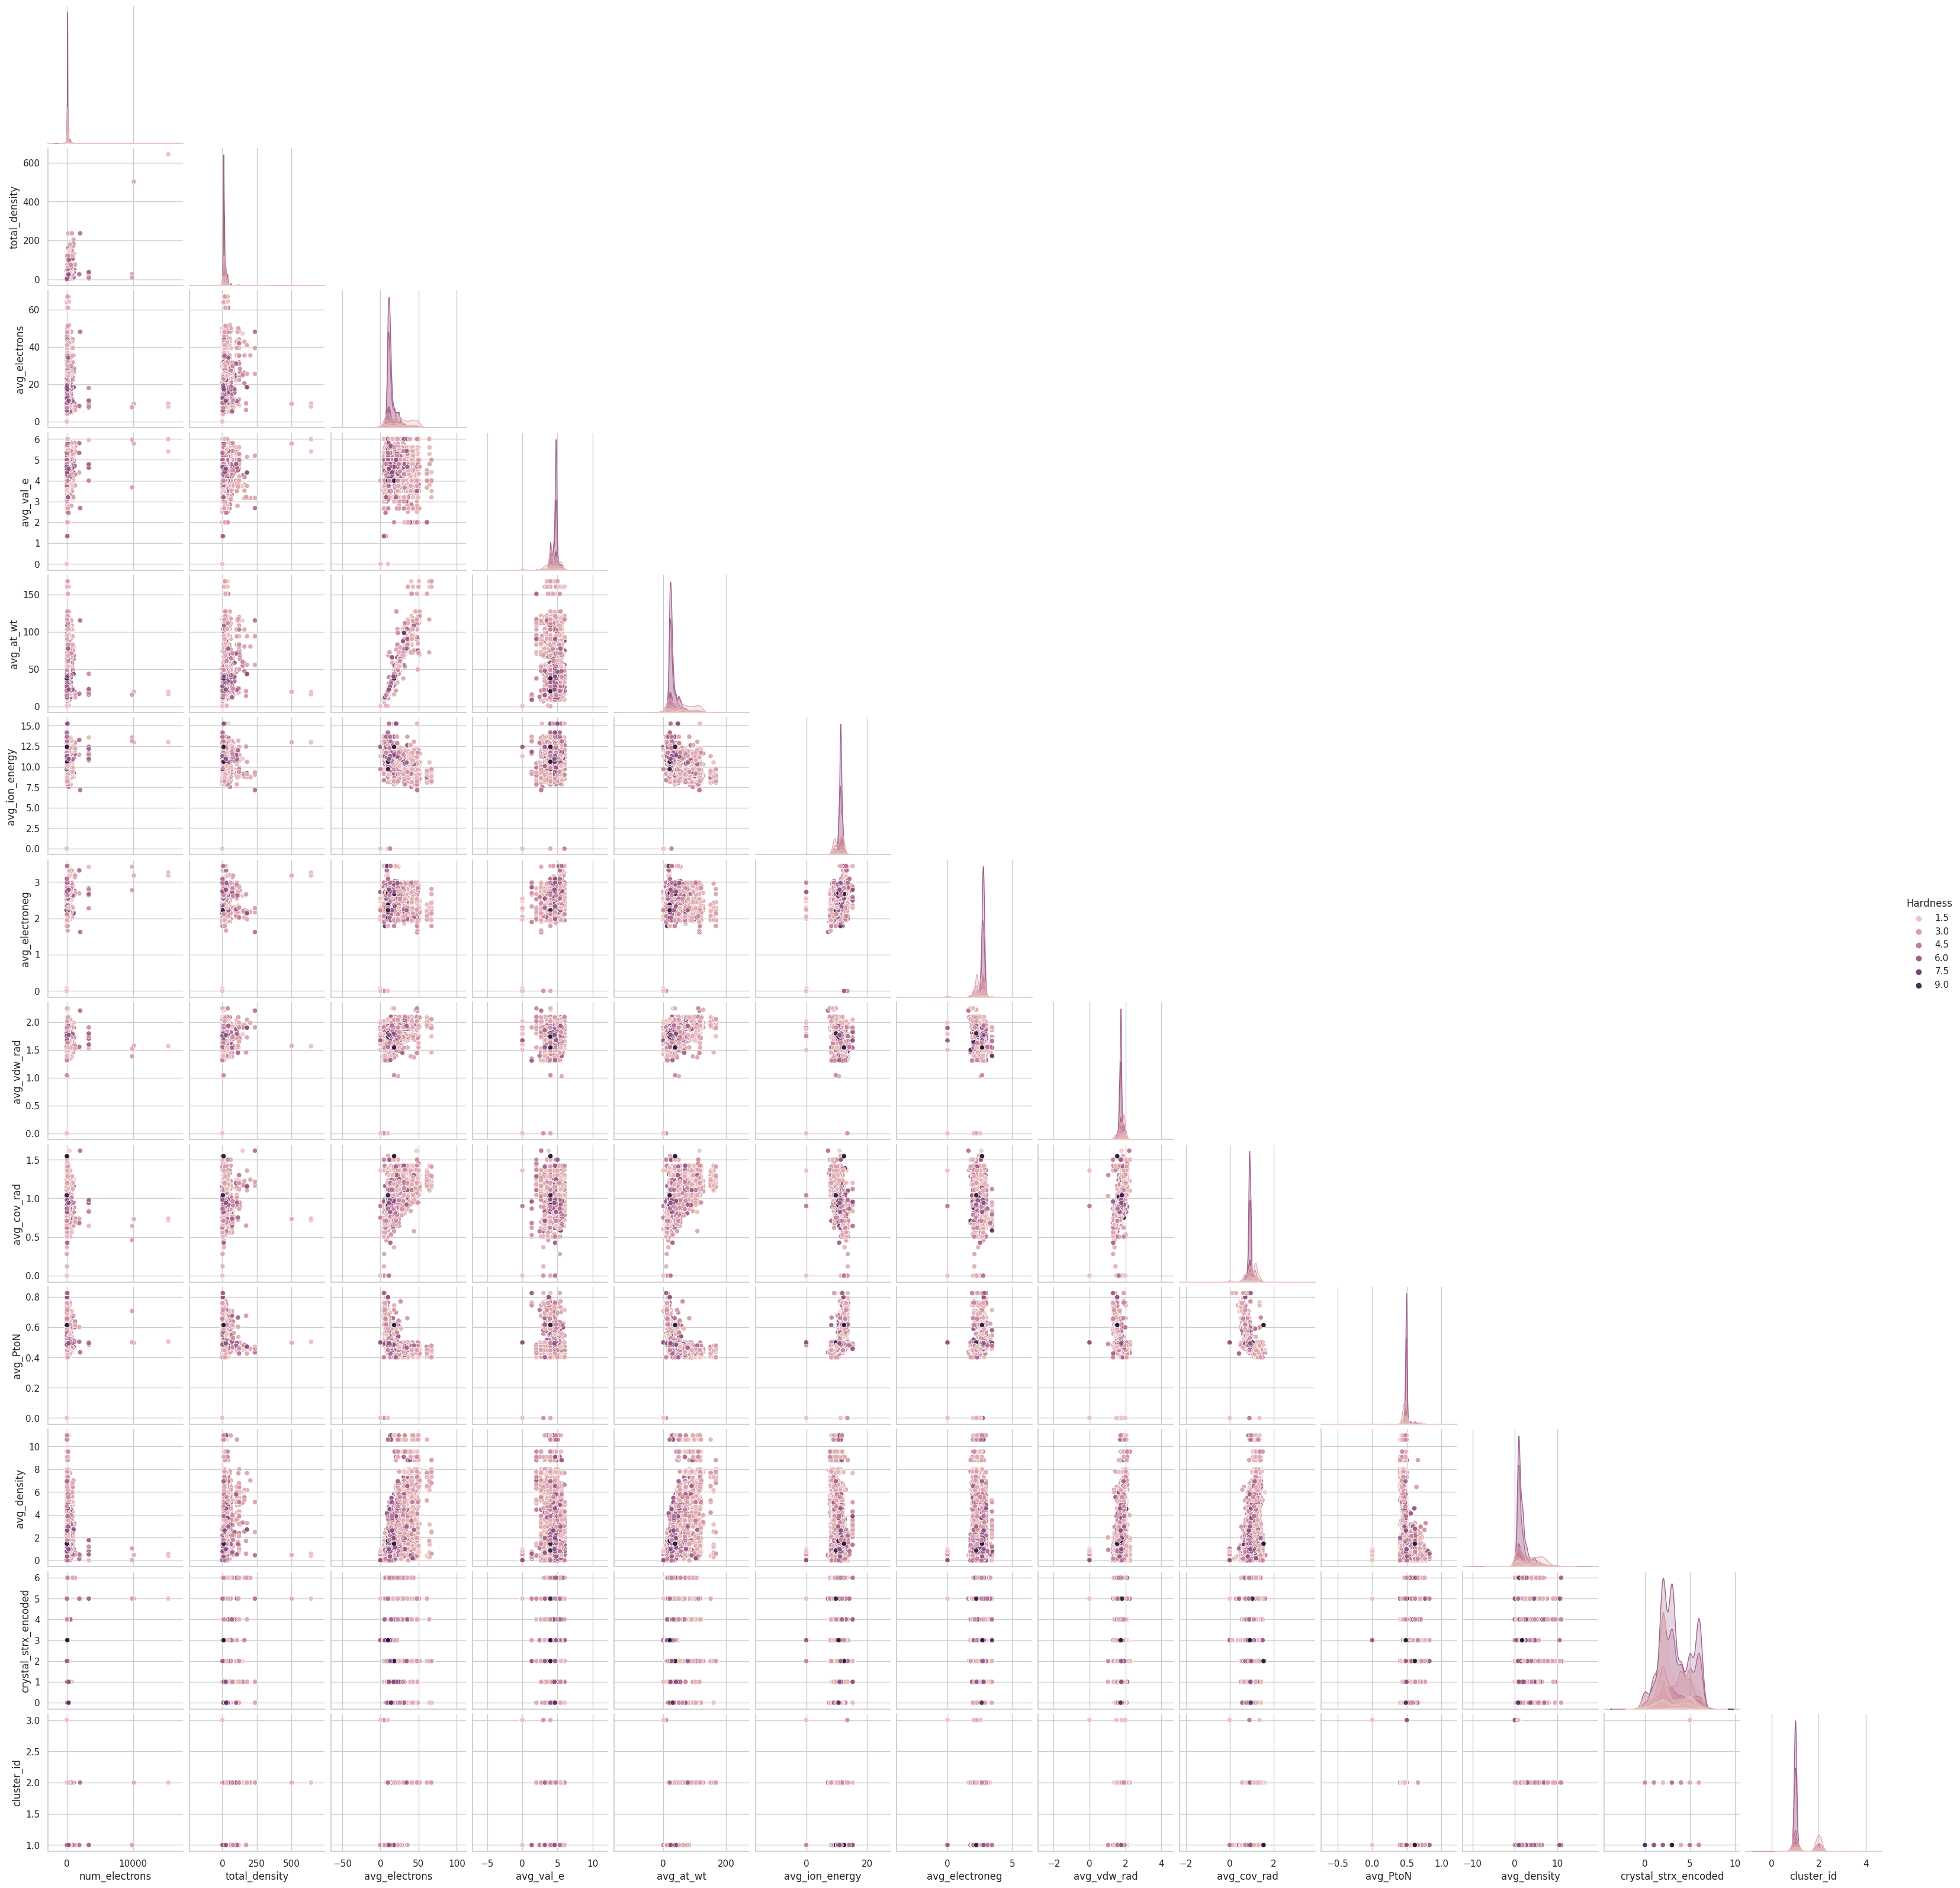

In [9]:
# Pairplot with target
sns.pairplot(X_plus_y, corner=True, diag_kind='kde', hue='Hardness')
plt.show()

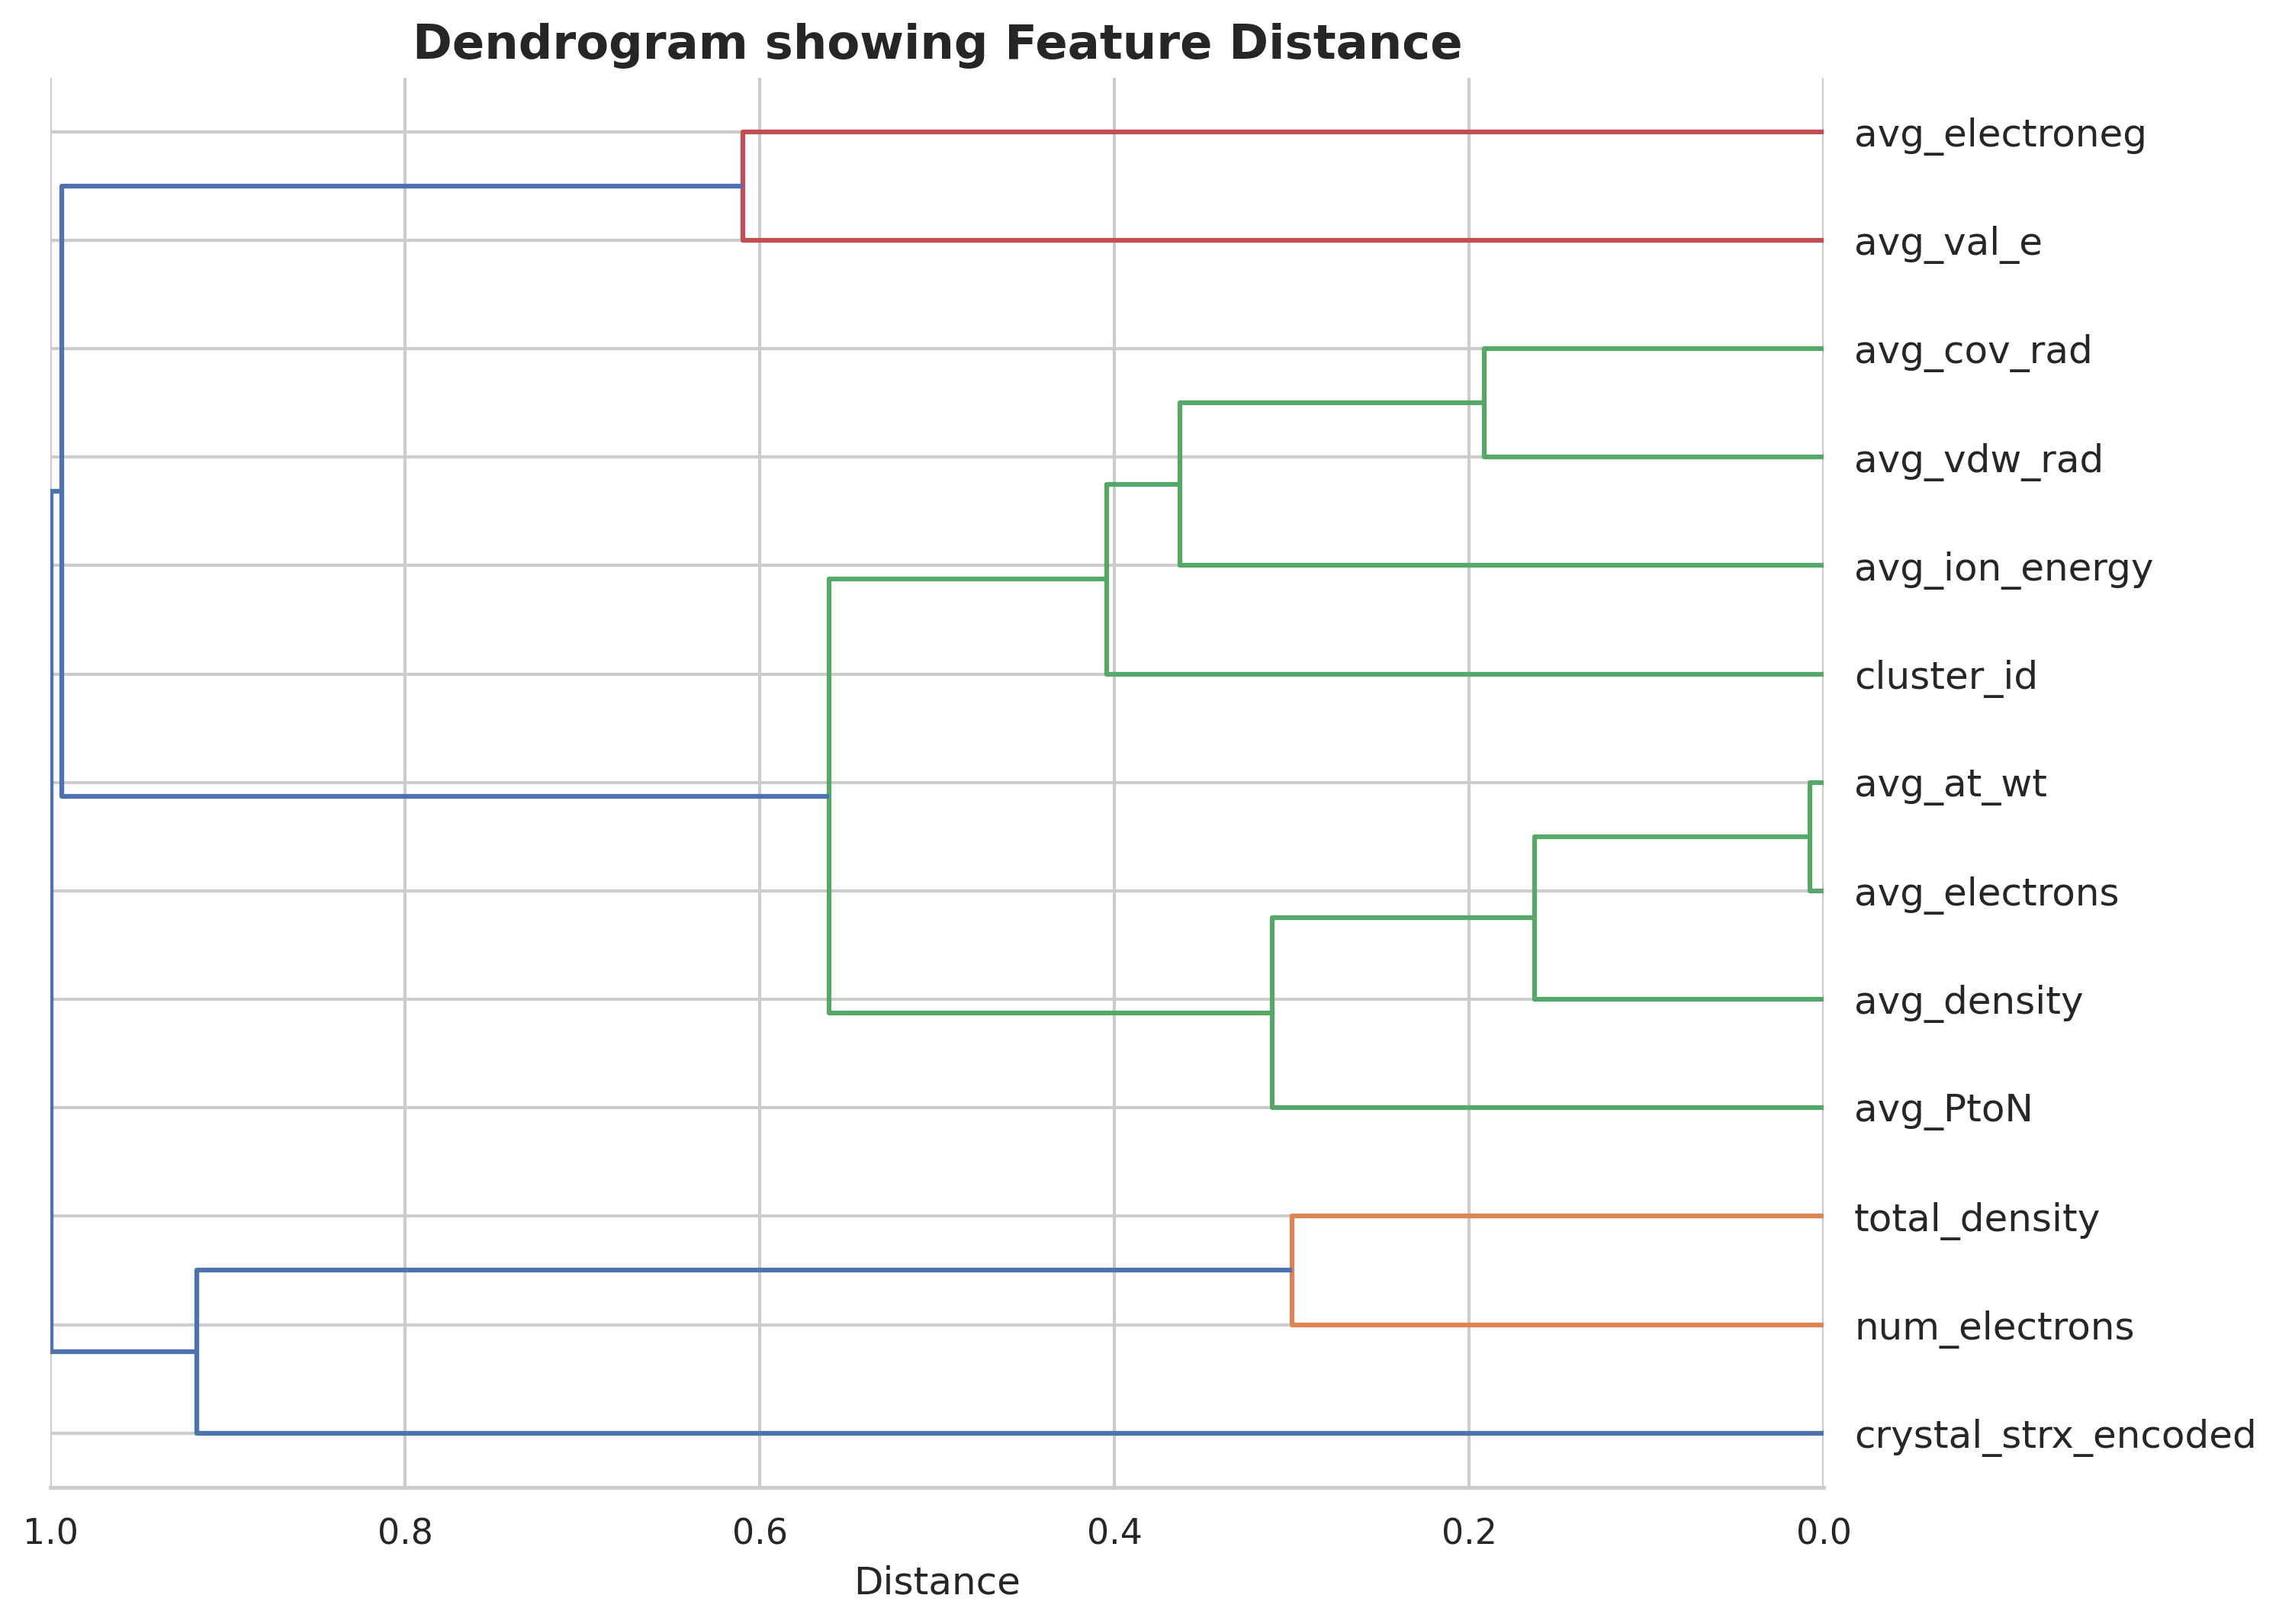

In [10]:
# I used the code for this from this notebook:
    # https://www.kaggle.com/code/iqbalsyahakbar/ps3e25-mohs-hardness-regression-for-beginners

# Dendrogram
corr = X.corr(method='spearman')
dist_linkage = linkage(squareform(1 - abs(corr)), 'complete')

plt.figure(figsize=(10, 8), dpi=300)
dendrogram(dist_linkage, labels=X.columns, orientation='left')  # Set orientation to 'left'

plt.title('Dendrogram showing Feature Distance', weight='bold', size=15)
plt.xlabel('Distance')  # Add x-axis label
plt.xlim(1.0, 0)
sns.despine(top=True, right=True, left=True)

plt.show()

<a id="3"></a>
### <span style="font=family:Arial; font-weight:bold; color:green; font-size:150%;">Adversarial validation</span>

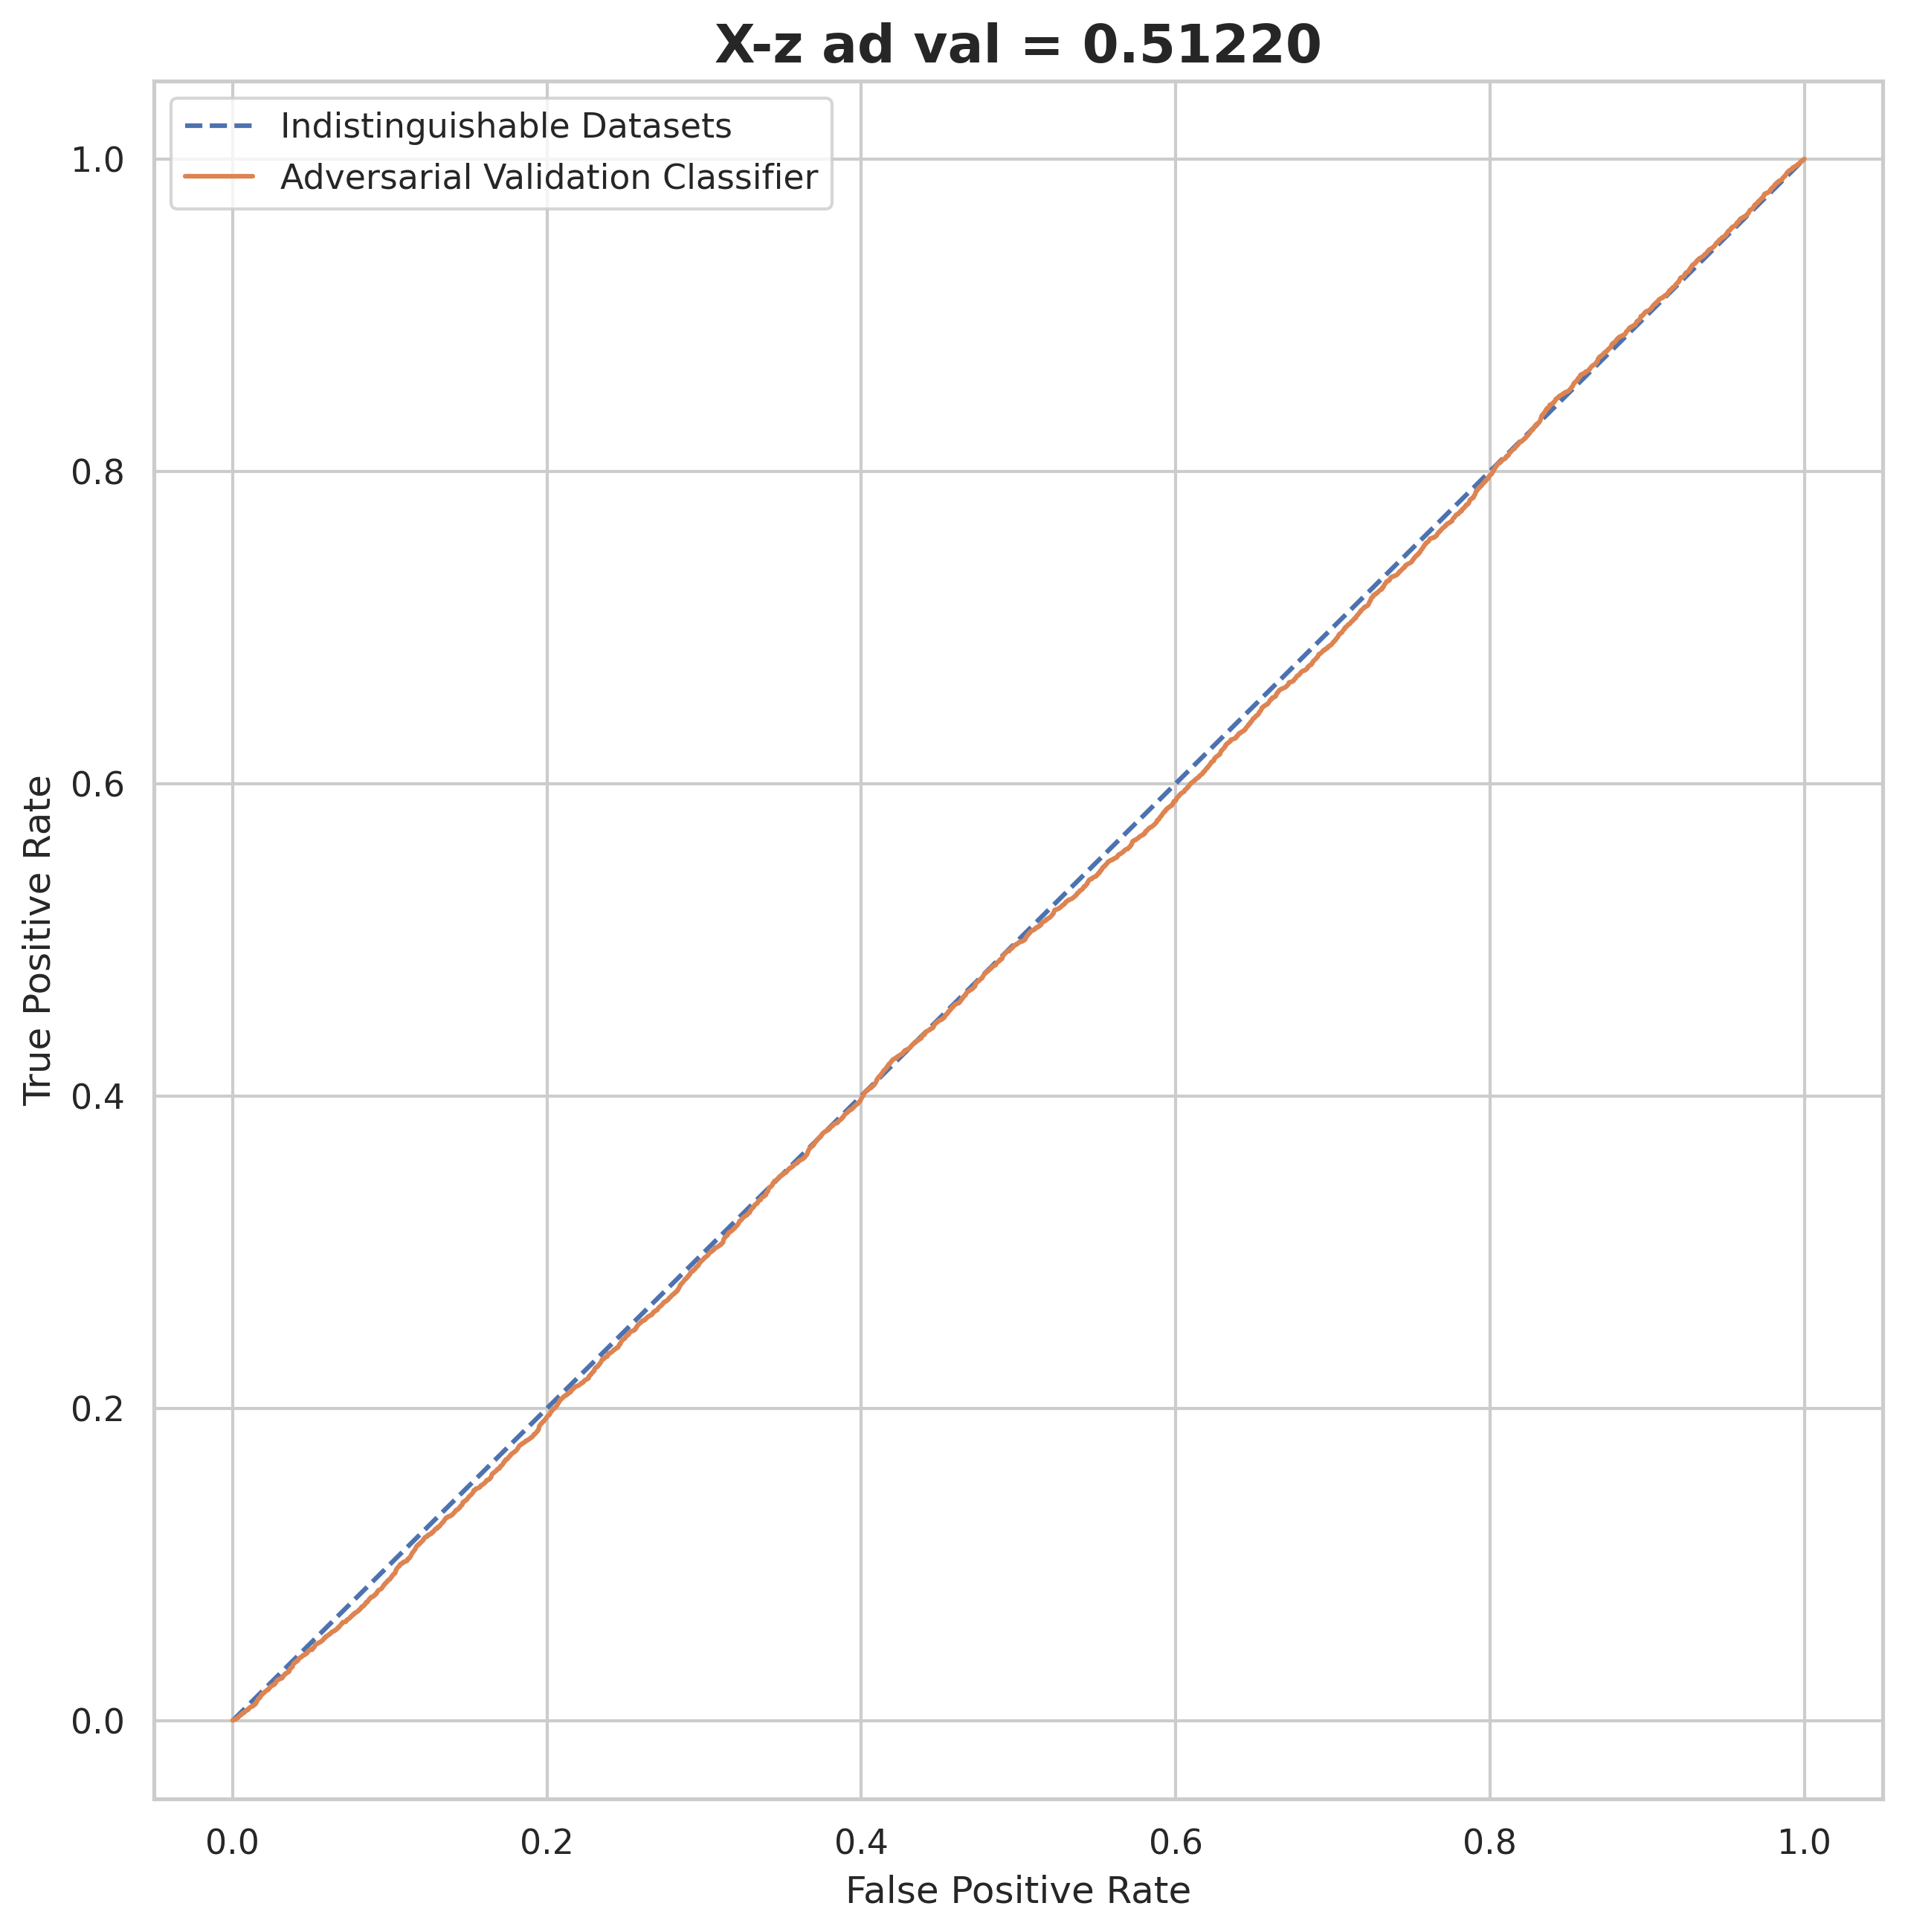

In [11]:
# I used this notebook to help me make my first ad_val
    # https://www.kaggle.com/code/iqbalsyahakbar/ps3e25-mohs-hardness-regression-for-beginners
    # https://www.kaggle.com/code/carlmcbrideellis/what-is-adversarial-validation

# Adversarial validation
adv_train = X.copy()
adv_test = z.copy()

adv_train['is_test'] = 0
adv_test['is_test'] = 1

adv = pd.concat([adv_train, adv_test], ignore_index = True)

adv_shuffled = adv.sample(frac = 1)

adv_X = adv_shuffled.drop('is_test', axis = 1)
adv_y = adv_shuffled.is_test

skf = StratifiedKFold(n_splits=FOLDS, random_state=SEED, shuffle=True)

val_scores = []
predictions = np.zeros(len(adv))

for fold, (train_idx, val_idx) in enumerate(skf.split(adv_X, adv_y)):

    adv_lr = XGBClassifier(random_state=SEED)
    adv_lr.fit(adv_X.iloc[train_idx], adv_y.iloc[train_idx])
    
    val_preds = adv_lr.predict_proba(adv_X.iloc[val_idx])[:,1]
    predictions[val_idx] = val_preds
    val_score = roc_auc_score(adv_y.iloc[val_idx], val_preds)
    val_scores.append(val_score)

fpr, tpr, _ = roc_curve(adv['is_test'], predictions)

plt.figure(figsize = (10, 10), dpi = 300)
sns.lineplot(x=[0, 1], y=[0, 1], linestyle="--", label="Indistinguishable Datasets")
sns.lineplot(x=fpr, y=tpr, label="Adversarial Validation Classifier")
plt.title(f'X-z ad val = {np.mean(val_scores):.5f}', weight = 'bold', size = 17)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()

In [12]:
def feature_engineering(df):
    # Drop num_electrons because it has high correlation only with total_density
    df = df.drop('num_electrons', axis=1)
    return df

X = feature_engineering(X)
z = feature_engineering(z)
print("Feature engineering complete...")

scaler = RobustScaler()
# X = scaler.fit_transform(X)
# z = scaler.fit_transform(z)
print("Data are scaled...")
print()

Feature engineering complete...
Data are scaled...



<a id="5"></a>
### <span style="font=family:Arial; font-weight:bold; color:green; font-size:150%;">Optuna code</span>
- **Note:** I *never* do optuna in my notebooks, entirely due to run time, but I figured this code could be helpful to some folks
- **Note:** I will put the trial number to 2 for it to run quickly, but on my personal machine I have it set to 1000 (which is probably overkill, realistically, I suggest 500 trials)
- **Note:** I will hide this code in case beginners want to take a look.

In [13]:
N_TRIALS = 2
xgb_optuna_scores  = []
lgbm_optuna_scores = []
cat_optuna_scores  = []
hgb_optuna_scores  = []

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=SEED)

# XGB OPTUNA ------------------

start_time = time.time()

def objective(trial):
    
    n_estimators = trial.suggest_int("n_estimators", 100, 1000)
    max_depth = trial.suggest_int("max_depth", 3, 10)
    eta = trial.suggest_float("eta", 0.01, 0.2)
    gamma = trial.suggest_float("gamma", 0.01, 3.0)
    reg_lambda = trial.suggest_float("reg_lambda", 1e-9, 100.0)
    alpha = trial.suggest_float("alpha", 1e-9, 100.0)
    min_child_weight = trial.suggest_int("min_child_weight", 1, 10)
    colsample_bytree = trial.suggest_float("colsample_bytree", 0.5, 1.0)
    subsample = trial.suggest_float("subsample", 0.5, 1.0)
    
    XGB = XGBRegressor(objective='reg:absoluteerror',
                       random_state=SEED,
                       n_jobs=-1,
                       n_estimators=n_estimators,
                       max_depth=max_depth,
                       eta=eta,
                       gamma=gamma,
                       reg_lambda=reg_lambda,
                       alpha=alpha,
                       min_child_weight=min_child_weight,
                       colsample_bytree=colsample_bytree,
                       subsample=subsample,
                       early_stopping_rounds=ROUNDS)
    
    with warnings.catch_warnings():
        warnings.filterwarnings("ignore", category=UserWarning, module="xgboost.sklearn")
        
        XGB.fit(X_train, y_train, 
                eval_metric='mae',
                eval_set = [(X_test,y_test)],
                verbose=False)
    
    xgb_score = median_absolute_error(y_test, XGB.predict(X_test))
    xgb_optuna_scores.append(xgb_score)
    
    return xgb_score


study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=N_TRIALS, n_jobs=-1)

# Get the best parameters
best_params = study.best_params
print()
print("Best XGB Params:", best_params)
print()
# Record end time
end_time = time.time()

# Calculate elapsed time in minutes with 2 decimal places
elapsed_time_minutes = round((end_time - start_time) / 60, 2)

# Print elapsed time
print(f"XGB optuning Time: {elapsed_time_minutes} minutes")

# Best params for N_TRIALS = 1000
xgb_params = {'n_estimators': 726, 'max_depth': 10, 'eta': 0.07613804584051358, 'gamma': 1.111993246238503, 
              'reg_lambda': 30.670711937824027, 'alpha': 10.2136072659197, 'min_child_weight': 6, 
              'colsample_bytree': 0.7838805588294807, 'subsample': 0.7366491220918466}

# LGBM OPTUNA ------------------

start_time = time.time()

def objective(trial):
    
    n_estimators = trial.suggest_int("n_estimators", 100, 1000)
    max_depth = trial.suggest_int("max_depth", 5, 10)
    learning_rate = trial.suggest_float("learning_rate", 0.01, 0.2)
    num_leaves = trial.suggest_int("num_leaves", 20, 300)
    min_data_in_leaf = trial.suggest_int("min_data_in_leaf", 20, 300)
    max_bin = trial.suggest_int("max_bin", 32, 255)
    lambda_l1 = trial.suggest_float("lambda_l1", 0, 1)
    lambda_l2 = trial.suggest_float("lambda_l2", 0, 1)
    min_gain_to_split = trial.suggest_float("min_gain_to_split", 0, 1)
    
    with warnings.catch_warnings():
        warnings.filterwarnings("ignore", category=UserWarning, module="lightgbm.sklearn")
    
        LGBM = LGBMRegressor(objective='mae',
                             random_state=SEED,
                             verbose=-1,
                             n_jobs=-1,
                             n_estimators=n_estimators,
                             max_depth=max_depth,
                             learning_rate=learning_rate,
                             num_leaves=num_leaves,
                             min_child_samples=min_data_in_leaf,
                             max_bin=max_bin,
                             reg_alpha=lambda_l1,
                             reg_lambda=lambda_l2,
                             min_split_gain=min_gain_to_split)
    
        LGBM.fit(X_train, y_train, 
                 eval_metric='mae',
                 eval_set = [(X_test, y_test)],
                 callbacks=[lightgbm.early_stopping(stopping_rounds=ROUNDS, verbose=False)])

    lgbm_score = median_absolute_error(y_test, LGBM.predict(X_test))
    lgbm_optuna_scores.append(lgbm_score)

    return lgbm_score

study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=N_TRIALS, n_jobs=-1)

# Get the best parameters
best_params = study.best_params
print()
print("Best LGBM params:", best_params)
print()
# Record end time
end_time = time.time()

# Calculate elapsed time in minutes with 2 decimal places
elapsed_time_minutes = round((end_time - start_time) / 60, 2)

# Print elapsed time
print(f"LGBM optuning Time: {elapsed_time_minutes} minutes")

# Best params for N_TRIALS = 1000
lgbm_params = {'n_estimators': 537, 'max_depth': 10, 'learning_rate': 0.08522253337076066, 'num_leaves': 47, 
                  'min_data_in_leaf': 20, 'max_bin': 221, 'lambda_l1': 0.5013146365935452, 'lambda_l2': 0.7724702319440833, 
                  'min_gain_to_split': 0.24215691067519887}

# CAT OPTUNA ------------------

start_time = time.time()

def objective(trial):
    
    iterations = trial.suggest_int("iterations", 100, 1000)
    max_depth = trial.suggest_int("max_depth", 5, 10)
    learning_rate = trial.suggest_float("learning_rate", 0.01, 0.2)
    bagging_temperature=trial.suggest_float('bagging_temperature', 0, 1)
    colsample_bylevel=trial.suggest_float('colsample_bylevel', 0.1, 1)
    l2_leaf_reg=trial.suggest_float('l2_leaf_reg', 1, 10)
    min_data_in_leaf=trial.suggest_float('min_data_in_leaf', 1, 30)
    max_bin=trial.suggest_int('max_bin', 2, 255)

    CAT = CatBoostRegressor(random_state=SEED,
                            verbose=0,
                            early_stopping_rounds=ROUNDS,
                            objective='MAE',
                            iterations=iterations,
                            max_depth=max_depth,
                            learning_rate=learning_rate,
                            bagging_temperature=bagging_temperature,
                            colsample_bylevel=colsample_bylevel,
                            l2_leaf_reg=l2_leaf_reg,
                            min_data_in_leaf=min_data_in_leaf,
                            max_bin=max_bin)
    
    CAT.fit(X_train, y_train, 
            eval_set = [(X_test, y_test)],
            early_stopping_rounds=ROUNDS)
    
    cat_score = median_absolute_error(y_test, CAT.predict(X_test))
    cat_optuna_scores.append(cat_score)

    return cat_score

study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=N_TRIALS, n_jobs=-1)

# Get the best parameters
best_params = study.best_params
print()
print("Best CAT Params:", best_params)
print()
# Record end time
end_time = time.time()

# Calculate elapsed time in minutes with 2 decimal places
elapsed_time_minutes = round((end_time - start_time) / 60, 2)

# Print elapsed time
print(f"CAT optuning Time: {elapsed_time_minutes} minutes")

# Best params for N_TRIALS = 1000
cat_params = {'iterations': 992, 'max_depth': 7, 'learning_rate': 0.09438684238968646, 
              'bagging_temperature': 0.9643077587174622, 'colsample_bylevel': 0.34036217165981436, 
              'l2_leaf_reg': 8.966674095841956, 'min_data_in_leaf': 13.258931282756468, 'max_bin': 238}

# HGB OPTUNA ------------------

start_time = time.time()

def objective(trial):
    
    max_iter = trial.suggest_int("max_iter", 100, 1000)
    max_depth = trial.suggest_int("max_depth", 5, 10)
    learning_rate = trial.suggest_float("learning_rate", 0.01, 0.2)
    min_samples_leaf=trial.suggest_int('min_smaples_leaf', 1, 100)
    max_leaf_nodes=trial.suggest_int('max_leaf_nodes', 1, 100)
    l2_regularization=trial.suggest_float('l2_regularization', 0, 1)
    max_bins=trial.suggest_int('max_bins', 2, 255)

    HGB = HistGradientBoostingRegressor(random_state=SEED,
                                        early_stopping='auto',
                                        loss='absolute_error',
                                        max_iter=max_iter,
                                        max_depth=max_depth,
                                        learning_rate=learning_rate,
                                        l2_regularization=l2_regularization,
                                        max_bins=max_bins,
                                        min_samples_leaf=min_samples_leaf,
                                        max_leaf_nodes=max_leaf_nodes)
    
    HGB.fit(X_train, y_train)
    
    hgb_score = median_absolute_error(y_test, HGB.predict(X_test))
    hgb_optuna_scores.append(hgb_score)

    return hgb_score

study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=N_TRIALS, n_jobs=-1)

# Get the best parameters
best_params = study.best_params
print()
print("Best HGB Params:", best_params)
print()
# Record end time
end_time = time.time()

# Calculate elapsed time in minutes with 2 decimal places
elapsed_time_minutes = round((end_time - start_time) / 60, 2)

# Print elapsed time
print(f"HGB optuning Time: {elapsed_time_minutes} minutes")

# Best params for N_TRIALS = 1000
hgb_params = {'max_iter': 946, 'max_depth': 10, 'learning_rate': 0.05769927601402044, 
              'min_smaples_leaf': 36, 'max_leaf_nodes': 61, 
              'l2_regularization': 0.4600658510642346, 'max_bins': 71}

[I 2023-11-21 18:26:44,978] A new study created in memory with name: no-name-435cec93-866f-428a-a8a1-44a73d1ac06e
[I 2023-11-21 18:26:46,891] Trial 0 finished with value: 0.5609395742416381 and parameters: {'n_estimators': 836, 'max_depth': 5, 'eta': 0.19782137288942325, 'gamma': 0.9112566394393665, 'reg_lambda': 15.330694719877606, 'alpha': 69.45190469036741, 'min_child_weight': 7, 'colsample_bytree': 0.8129399232924834, 'subsample': 0.8024110134099876}. Best is trial 0 with value: 0.5609395742416381.
[I 2023-11-21 18:26:48,769] Trial 1 finished with value: 0.5099656581878662 and parameters: {'n_estimators': 916, 'max_depth': 5, 'eta': 0.08965790472783447, 'gamma': 1.3594093592633707, 'reg_lambda': 89.9182133390545, 'alpha': 4.105724665939124, 'min_child_weight': 10, 'colsample_bytree': 0.8013238606367676, 'subsample': 0.5381447409334035}. Best is trial 1 with value: 0.5099656581878662.
[I 2023-11-21 18:26:48,772] A new study created in memory with name: no-name-e985979f-2908-4f81-8ed


Best XGB Params: {'n_estimators': 916, 'max_depth': 5, 'eta': 0.08965790472783447, 'gamma': 1.3594093592633707, 'reg_lambda': 89.9182133390545, 'alpha': 4.105724665939124, 'min_child_weight': 10, 'colsample_bytree': 0.8013238606367676, 'subsample': 0.5381447409334035}

XGB optuning Time: 0.06 minutes


[I 2023-11-21 18:26:50,675] Trial 0 finished with value: 0.5237706302699476 and parameters: {'n_estimators': 969, 'max_depth': 7, 'learning_rate': 0.12704695754741296, 'num_leaves': 227, 'min_data_in_leaf': 220, 'max_bin': 250, 'lambda_l1': 0.33369661992529687, 'lambda_l2': 0.8477363236975332, 'min_gain_to_split': 0.6683232639694544}. Best is trial 0 with value: 0.5237706302699476.
[I 2023-11-21 18:26:50,766] Trial 1 finished with value: 0.5240134339416325 and parameters: {'n_estimators': 992, 'max_depth': 7, 'learning_rate': 0.05686521948747137, 'num_leaves': 205, 'min_data_in_leaf': 294, 'max_bin': 176, 'lambda_l1': 0.441554622982706, 'lambda_l2': 0.12883699037933072, 'min_gain_to_split': 0.9034274243450524}. Best is trial 0 with value: 0.5237706302699476.
[I 2023-11-21 18:26:50,771] A new study created in memory with name: no-name-6b8677da-b7cf-4411-9f91-6e277fc8fd33
TBB Warning: The number of workers is currently limited to 0. The request for 3 workers is ignored. Further requests 


Best LGBM params: {'n_estimators': 969, 'max_depth': 7, 'learning_rate': 0.12704695754741296, 'num_leaves': 227, 'min_data_in_leaf': 220, 'max_bin': 250, 'lambda_l1': 0.33369661992529687, 'lambda_l2': 0.8477363236975332, 'min_gain_to_split': 0.6683232639694544}

LGBM optuning Time: 0.03 minutes


[I 2023-11-21 18:26:54,106] Trial 0 finished with value: 0.5373864459572464 and parameters: {'iterations': 321, 'max_depth': 7, 'learning_rate': 0.18319163312180686, 'bagging_temperature': 0.17452012853943322, 'colsample_bylevel': 0.9039727862515351, 'l2_leaf_reg': 2.240515643040617, 'min_data_in_leaf': 6.031818321482781, 'max_bin': 99}. Best is trial 0 with value: 0.5373864459572464.
[I 2023-11-21 18:26:54,514] Trial 1 finished with value: 0.5266199667762033 and parameters: {'iterations': 452, 'max_depth': 6, 'learning_rate': 0.19533959074189622, 'bagging_temperature': 0.6929975696735178, 'colsample_bylevel': 0.9775252095913801, 'l2_leaf_reg': 6.317264806422473, 'min_data_in_leaf': 1.0763976004478057, 'max_bin': 205}. Best is trial 1 with value: 0.5266199667762033.
[I 2023-11-21 18:26:54,517] A new study created in memory with name: no-name-839e47ae-f8bd-41a3-bf3d-e5cbc4af74bc



Best CAT Params: {'iterations': 452, 'max_depth': 6, 'learning_rate': 0.19533959074189622, 'bagging_temperature': 0.6929975696735178, 'colsample_bylevel': 0.9775252095913801, 'l2_leaf_reg': 6.317264806422473, 'min_data_in_leaf': 1.0763976004478057, 'max_bin': 205}

CAT optuning Time: 0.06 minutes


[I 2023-11-21 18:27:02,258] Trial 0 finished with value: 0.49805822395069166 and parameters: {'max_iter': 643, 'max_depth': 6, 'learning_rate': 0.14830779218314816, 'min_smaples_leaf': 45, 'max_leaf_nodes': 67, 'l2_regularization': 0.9383590186880785, 'max_bins': 200}. Best is trial 0 with value: 0.49805822395069166.
[I 2023-11-21 18:27:06,362] Trial 1 finished with value: 0.48289183792664314 and parameters: {'max_iter': 635, 'max_depth': 9, 'learning_rate': 0.059202956918449866, 'min_smaples_leaf': 25, 'max_leaf_nodes': 70, 'l2_regularization': 0.17478179014175366, 'max_bins': 118}. Best is trial 1 with value: 0.48289183792664314.



Best HGB Params: {'max_iter': 635, 'max_depth': 9, 'learning_rate': 0.059202956918449866, 'min_smaples_leaf': 25, 'max_leaf_nodes': 70, 'l2_regularization': 0.17478179014175366, 'max_bins': 118}

HGB optuning Time: 0.2 minutes


<a id="7"></a>
### <span style="font=family:Arial; font-weight:bold; color:green; font-size:150%;">Voting</span>

In [14]:
%%time
# Voting

voting_scores = []
voting_preds = []
kfold = KFold(n_splits=FOLDS, shuffle=True, random_state=SEED)

lgbm_params = {'n_estimators': 537, 'max_depth': 10, 'learning_rate': 0.08522253337076066, 
               'num_leaves': 47, 'min_data_in_leaf': 20, 'max_bin': 221, 
               'lambda_l1': 0.5013146365935452, 'lambda_l2': 0.7724702319440833,
               'min_gain_to_split': 0.24215691067519887}

LGBM = LGBMRegressor(objective='mae',
                     random_state=SEED,
                     verbose=-1,
                     n_jobs=-1,
                     **lgbm_params)

hgb_params = {'max_iter': 946, 'max_depth': 10, 'learning_rate': 0.05769927601402044, 
              'min_samples_leaf': 36, 'max_leaf_nodes': 61, 
              'l2_regularization': 0.4600658510642346, 'max_bins': 71}

HGB = HistGradientBoostingRegressor(random_state=SEED, 
                                    loss='absolute_error',
                                    **hgb_params)

for fold_idx, (train_idx, test_idx) in enumerate(kfold.split(X, y), start=1):
    X_train, y_train = X.iloc[train_idx], y.iloc[train_idx]
    X_test,  y_test   = X.iloc[test_idx], y.iloc[test_idx]
    
    voting_regressor = VotingRegressor(estimators = [('LGBM', LGBM), ('HGB', HGB)],
                                       n_jobs = -1, 
                                       weights = [2, 3])
    
    voter = voting_regressor.fit(X_train, y_train)
    voting_train_preds = voter.predict(X_test)
    
    voting_score = median_absolute_error(y_test, voting_train_preds)
    voting_scores.append(voting_score)
    
    print(f"Fold {fold_idx}: {voting_score:.5f}")
    
    voting_test_preds = voter.predict(z)
    voting_preds.append(voting_test_preds)

print()
print("Voting  Score:", np.mean(voting_scores))
print("Voting    Std:", np.std(voting_scores))
print()

[LightGBM] [Warning] lambda_l1 is set=0.5013146365935452, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5013146365935452
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_gain_to_split is set=0.24215691067519887, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.24215691067519887
[LightGBM] [Warning] lambda_l2 is set=0.7724702319440833, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.7724702319440833
Fold 1: 0.46962
[LightGBM] [Warning] lambda_l1 is set=0.5013146365935452, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5013146365935452
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_gain_to_split is set=0.24215691067519887, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.24215691067519887
[LightGBM] [Warning] lambda_

<a id="9"></a>
### <span style="font=family:Arial; font-weight:bold; color:green; font-size:150%;">Submission form</span>

In [15]:
voting_regressor = VotingRegressor(estimators = [('LGBM', LGBM),('HGB', HGB)],
                                   n_jobs = -1, 
                                   weights = [2, 3])

voter = voting_regressor.fit(X, y)
voting_preds = voter.predict(z)

sample['Hardness'] = voting_preds
print(sample.head(3))
sample.to_csv("submission.csv", index = False)
print()
print("File submitted...")
print("You've earned yourself a coffee...")

[LightGBM] [Warning] lambda_l1 is set=0.5013146365935452, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5013146365935452
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_gain_to_split is set=0.24215691067519887, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.24215691067519887
[LightGBM] [Warning] lambda_l2 is set=0.7724702319440833, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.7724702319440833
      id  Hardness
0  10407  2.511177
1  10408  2.605365
2  10409  5.990976

File submitted...
You've earned yourself a coffee...


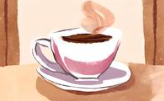

<a id="10"></a>
### <span style="font=family:Arial; font-weight:bold; color:green; font-size:150%;">TO DO LIST</span>
1. Neural networks are performing really well in this competition. I should try a couple, including TabNet.
2. Do simple arithmetic feature engineering to find more information rich features.
3. Try different scaling techniques with a pipeline to make it easy to understand.
4. Try different weights from what's being discussed.
5. If there's anything else you think I can add, please leave a comment!